# Data Wrangling
## Table of Contents
- [Requirements](#requirements)
- [Set Up](#set-up)
- [Dataset Structuring](#dataset-structuring)
  - [Average Temperature, Total Precipitation, & PDSI Score](#average-temperature,-total-precipitation,-&-pdsi-score)
  - [Six Month Average Temperature & Total Precipitation](#six-month-average-temperature-&-total-precipitation)
  - [Population Density](#population-density)
  - [Price Received](#price-recieved)
  - [Grain & Silage Yield](#grain-&-silage-yield)
  - [Applications](#applications)
  - [Moisture Scores](#moisture-scores)
  - [Six Month Average Moisture Scores](#six-month-average-moisture-scores)
- [Exploring Nullity & Correlation](#exploring-nullity-&-correlation)
  - [Yearly Variables](#yearly-variables)
  - [Monthly Variables](#monthly-variables)
  - [Scatterplots](#scatterplots)
- [Making Lagged Variables](#making-lagged-variables)
- [Boxplots, Histograms, & Heatmap](#boxplots,-histograms,-&-heatmap)

## Requirements

In [2]:
import glob
import math
import itertools
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

## Set Up

In [3]:
states = ['illinois', 'indiana', 'iowa', 'minnesota', 'missouri', 'nebraska']
months = ['april', 'may', 'june', 'july', 'august', 'september', 'october', 'november']
years = list(range(1895, 2025))*6
years.sort()
list_temp = list(range(0, 6))*130
vars_iterable = ['avg-temp', 'precipitation', 'pdsi']
df_empty = pd.DataFrame({'year':years, 'state':list_temp})
df_empty['state'] = df_empty['state'].replace({i: states[i] for i in range(len(states))})
all_vars = [
            'year',
            'state',
            'fungicide (lb/acre)', 'herbicide (lb/acre)', 'insecticide (lb/acre)', 'other chemicals (lb/acre)', 'fertilizer (lb/acre)',
            'april-nov-avg-temp', 'april-nov-precipitation', 'april-nov-pdsi',
            'april-avg-temp', 'may-avg-temp', 'june-avg-temp', 'july-avg-temp', 'august-avg-temp', 'september-avg-temp', 'october-avg-temp', 'november-avg-temp', 'april-precipitation', 'may-precipitation', 'june-precipitation', 'july-precipitation', 'august-precipitation', 'september-precipitation', 'october-precipitation', 'november-precipitation', 'april-pdsi', 'may-pdsi', 'june-pdsi', 'july-pdsi', 'august-pdsi', 'september-pdsi', 'october-pdsi', 'november-pdsi',
            'population-density',
            'price-received',
            'grain-yield', 'silage-yield',
            'subsoil-score-april', 'subsoil-score-may', 'subsoil-score-june', 'subsoil-score-july', 'subsoil-score-august', 'subsoil-score-september', 'subsoil-score-october', 'topsoil-score-april', 'topsoil-score-may', 'topsoil-score-june', 'topsoil-score-july', 'topsoil-score-august', 'topsoil-score-september', 'topsoil-score-october',
            'april-nov-subsoil-score', 'april-nov-topsoil-score'
            ]

## Dataset Structuring

### Average Temperature, Total Precipitation, & PDSI Score

In [4]:
# avg-temp-precipitation-pdsi.csv

df2 = df_empty.copy()

# loop through each state, variable, and month
for state in states:
    for var in vars_iterable:
        for month in months:

            # read csv and skip the appropriate number of rows
            df_temp = pd.read_csv(f'../data/{state}/raw/{month}-{var}.csv', skiprows=3 if var == 'pdsi' else 4)

            # reformat the `Date` column to be YYYY
            df_temp['Date'] = df_temp['Date'].apply(lambda x: int(str(x)[:4]))

            # rename `Date` to `year`
            df_temp.rename(columns={'Date':'year'}, inplace=True)

            # rename `Value` columns to `{month}-{var}`
            df_temp.rename(columns={'Value':f'{month}-{var}'}, inplace=True)

            # map the `df_temp` values to `df2`
            df2.loc[df2['state'] == state, f'{month}-{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_temp.set_index('year')[f'{month}-{var}'])

# export the final csv to data/all/processed
df2.to_csv('../data/all/processed/avg-temp-precipitation-pdsi.csv', index=False)

### Six Month Average Temperature & Total Precipitation

In [5]:
# april-november-avg-temp-precipitation.csv

df2 = df_empty.copy()

# loop through each state and variable
for state in states:
    for var in vars_iterable[0:2]:

        # read csv and skip the appropriate number of rows
        df_temp = pd.read_csv(f'../data/{state}/raw/april-november-{var}.csv', skiprows=4)

        # reformat the `Date` column to be YYYY
        df_temp['Date'] = df_temp['Date'].apply(lambda x: int(str(x)[:4]))

        # map the `df_temp` values to `df2`
        df2.loc[df2['state'] == state, 'april-nov-'+var] = df2.loc[df2['state'] == state, 'year'].map(df_temp.set_index('Date')['Value'])

    # loop through each month
    for month in months:

        # read csv and skip the appropriate number of rows
        df_temp = pd.read_csv(f'../data/{state}/raw/{month}-pdsi.csv', skiprows=3)

        # reformat the `Date` column to be YYYY
        df_temp['Date'] = df_temp['Date'].apply(lambda x: int(str(x)[:4]))

        # rename `Date` to `year`
        df_temp.rename(columns={'Date':'year'}, inplace=True)

        # rename `Value` columns to `{month}-pdsi`
        df_temp.rename(columns={'Value':f'{month}-pdsi'}, inplace=True)

        # map the `df_temp` values to `df2`
        df2.loc[df2['state'] == state, f'{month}-pdsi'] = df2.loc[df2['state'] == state, 'year'].map(df_temp.set_index('year')[f'{month}-pdsi'])

# create new column, `april-noc-pdsi`
df2['april-nov-pdsi'] = sum(df2[f'{col}'] for col in df2.columns[5:]) / len(df2.columns[5:])

# drop the unnecessary columns
df2.drop(columns=df2.columns[4:12], inplace=True)

# export the final csv to data/all/processed
df2.to_csv('../data/all/processed/april-november-avg-temp-precipitation-pdsi.csv', index=False)

### Population Density

In [6]:
# population-density.csv

df_area = pd.read_csv('../data/all/raw/state-area.csv')
df_area['state'] = df_area['state'].str.lower()
df_area = df_area[['state', 'total_area_sq_mi']]
df2 = df_empty.merge(df_area, on='state', how='inner')

# loop through each state
for state in states:

    # read csv and skip the appropriate number of rows
    df_temp = pd.read_csv(f'../data/{state}/raw/population.csv', skiprows=15)

    # reformat the `date` column to be YYYY in a new column, `year`
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp['year'] = df_temp['date'].dt.year
    df_temp['state'] = f'{state}'

    # map the `df_temp` values to `df2`
    df2.loc[df2['state'] == state, 'population'] = df2.loc[df2['state'] == state, 'year'].map(df_temp.set_index('year')[' Population'])

# create new column, `population-density`
df2['population-density'] = df2['population'] / df2['total_area_sq_mi']

# reduce df2 to only `year`, `state`, and `population-density`
df2.drop(columns=['total_area_sq_mi', 'population'], inplace=True)

# export the final csv to data/all/processed
df2.to_csv('../data/all/processed/population-density.csv', index=False)

### Price Received

In [7]:
for state in states:
    df_temp = pd.read_csv(f"../data/{state}/raw/price-received.csv")
    df_temp  = df_temp[["Year", "Value"]].rename(columns = {"Year": "year", "Value": "price-received"})
    df_temp.to_csv(f"../data/{state}/processed/price-received.csv", index=False)

In [8]:
# price-received.csv

df2 = df_empty.copy()

# loop through each state
for state in states:

    # read csv
    df_state = pd.read_csv(f'../data/{state}/processed/price-received.csv')

    # map the `df_temp` values to `df2`
    df2.loc[df2['state'] == state, 'price-received'] = df2.loc[df2['state'] == state, 'year'].map(df_state.set_index('year')['price-received'])

# export the final csv to data/all/processed
df2.to_csv('../data/all/processed/price-received.csv', index=False)

### Grain & Silage Yield

In [9]:
# yield.csv

df2 = df_empty.copy()

# loop through each state
for state in states:
    
    # read csv
    df_state = pd.read_csv(f'../data/{state}/raw/yield.csv')

    # create new column, `grain-yield`
    df_state['State'] = df_state['State'].str.lower()
    df_state_grain = df_state[df_state['Data Item'] == f"{df_state['Data Item'].unique()[0]}"].copy()
    df_state_grain.rename(columns={'Year':'year', 'State':'state', 'Value':'grain-yield'}, inplace=True)

    # map the `df_temp` values to `df2`
    df2.loc[df2['state'] == state, 'grain-yield'] = df2.loc[df2['state'] == state, 'year'].map(df_state_grain.set_index('year')['grain-yield'])

    # create new column, `silage-yield`
    df_state_silage = df_state[df_state['Data Item'] == f"{df_state['Data Item'].unique()[1]}"].copy()
    df_state_silage.rename(columns={'Year':'year', 'State':'state', 'Value':'silage-yield'}, inplace=True)

    # map the `df_temp` values to `df2`
    df2.loc[df2['state'] == state, 'silage-yield'] = df2.loc[df2['state'] == state, 'year'].map(df_state_silage.set_index('year')['silage-yield'])

# export the final csv to data/all/processed
df2.to_csv('../data/all/processed/yield.csv', index=False)

### Applications

In [10]:
def clean_applications(filename: str):
    # read the file
    df = pd.read_csv(filename) 
    # discard irrevant columns
    df = df[["State", "Year", "Domain", "Value"]]
    # convert value to numeric
    df["Value"] = pd.to_numeric(df["Value"], errors='coerce')
    # group chemical domains together
    df = df.groupby(["State", "Year", "Domain"]).agg("sum").reset_index()
    # pivot on domain
    df = df.pivot(index=["State", "Year"], columns=["Domain"], values=["Value"]).reset_index()
    # set indexes
    df.set_index(["State", "Year"], inplace=True)
    # clean column names
    df.columns = ["fungicide (lb/acre)", "herbicide (lb/acre)", "insecticide (lb/acre)", "other chemicals (lb/acre)", "fertilizer (lb/acre)"]
    # collapse indexes
    df = df.reset_index()
    df.rename(columns={"State": "state", "Year": "year"}, inplace=True)

    # set state names to lowercase
    df["state"] = df["state"].apply(lambda x: x.casefold())
    
    return df

In [11]:
# clean applications for each state and concatenate into a master dataframe
states = ["illinois", "indiana", "iowa", "minnesota", "missouri", "nebraska"]
dataframes = [clean_applications(f"../data/{state}/raw/applications.csv") for state in states]
master_applications = pd.concat(dataframes)
master_applications.to_csv("../data/all/processed/applications.csv", index=False)

### Moisture Scores

In [12]:
def clean_moisture(filename: str, state: str):
    # read the file
    df = pd.read_csv(filename)
    # discard irrelevant columns
    df = df[["Year", "Week Ending", "Data Item", "Value"]]
    # pivot on Data Item
    df = df.pivot(index=["Year", "Week Ending"], columns=["Data Item"], values=["Value"]).reset_index()
    # set indexes
    df.set_index(["Year", "Week Ending"], inplace=True)
    # rename columns
    df.columns = ["subsoil mositure (pct adequate)", "subsoil moisture (pct short)", "subsoil moisture (pct surplus)", "subsoil moisture (pct very short)", "topsoil moisture (pct adequate)", "topsoil moisture (pct short)", "topsoil moisture (pct surplus)", "topsoil moisture (pct very short)"]
    # collapse indexes
    df = df.reset_index().rename(columns={"Year": "year", "Week Ending": "week ending"})
    # add state column
    df["state"] = state
    # add month column
    df["week ending"] = pd.to_datetime(df["week ending"])
    df["month"] = df["week ending"].apply(lambda x: x.month_name().casefold())
    df["month"] = pd.CategoricalIndex(df["month"], categories=["april", "may", "june", "july", "august", "september", "october", "november"])
    # group by month
    df = df.groupby(["state", "year", "month"]).agg("mean").reset_index()
    # add scoring columns
    df["topsoil score"] = 1 * df["topsoil moisture (pct very short)"] + 2 * df["topsoil moisture (pct short)"] + 3 * df["topsoil moisture (pct adequate)"] + 4 * df["topsoil moisture (pct surplus)"]
    df["subsoil score"] = 1 * df["subsoil moisture (pct very short)"] + 2 * df["subsoil moisture (pct short)"]+ 3 * df["subsoil mositure (pct adequate)"] + 4 * df["subsoil moisture (pct surplus)"]
    # reorder columns
    df = df[["state", "year", "month", "subsoil score", "topsoil score"]]

    return df

In [13]:
# clean moisture for each state and concatenate into a master dataframe
states = ["illinois", "indiana", "iowa", "minnesota", "missouri", "nebraska"]
dataframes = [clean_moisture(f"../data/{state}/raw/moisture.csv", state=state) for state in states]
master_moisture = pd.concat(dataframes)
master_moisture = master_moisture.pivot(index=["state", "year"], columns=["month"], values=["subsoil score", "topsoil score"]).reset_index()
master_moisture.set_index(["state", "year"], inplace=True)
master_moisture.columns = [' '.join(col).strip() for col in master_moisture.columns.values]
master_moisture.columns = [x.replace(" ", "-") for x in master_moisture.columns]

# create lagged columns
for col in master_moisture.columns:
    master_moisture[col + "-lagged"] = np.roll(master_moisture[col], 1)
    master_moisture.loc[0, col + "-lagged"] = None

master_moisture.reset_index(inplace=True)
master_moisture.to_csv("../data/all/processed/moisture.csv", index=False)

/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/851729682.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(["state", "year", "month"]).agg("mean").reset_index()
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/851729682.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(["state", "year", "month"]).agg("mean").reset_index()
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/851729682.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False 

### Six Month Average Moisture Scores

In [14]:
# april-november-moisture.csv

df2 = pd.read_csv('../data/all/processed/moisture.csv')

# create new column, `april-nov-subsoil-score`
df2['april-nov-subsoil-score'] = sum(df2[f'{col}'] for col in df2.columns[2:9]) / len(df2.columns[2:9])

# create new column, `april-nov-topsoil-score`
df2['april-nov-topsoil-score'] = sum(df2[f'{col}'] for col in df2.columns[9:16]) / len(df2.columns[9:16])

# reduce df2 to only the columns of interest
df2 = df2[['year', 'state', 'april-nov-subsoil-score', 'april-nov-topsoil-score']]

# export the final csv to data/all/processed
df2.to_csv('../data/all/processed/april-november-moisture.csv', index=False)

## Exploring Nullity & Correlation

In [15]:
df2 = pd.DataFrame({'year': years, 'state': list_temp})
for var in all_vars[2:]:
    df2[var] = None
df2['state'] = df2['state'].replace({i: states[i] for i in range(len(states))})

for i, var in enumerate(all_vars):

    if 2 <= i <= 6:
        df_csv = pd.read_csv('../data/all/processed/applications.csv')
        for state in states:
            df2.loc[df2['state'] == state, f'{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_csv[df_csv['state'] == f'{state}'].set_index('year')[f'{var}'])

    elif 7 <= i <= 9:
        df_csv = pd.read_csv('../data/all/processed/april-november-avg-temp-precipitation-pdsi.csv')
        for state in states:
            df2.loc[df2['state'] == state, f'{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_csv[df_csv['state'] == f'{state}'].set_index('year')[f'{var}'])

    elif 10 <= i <= 33:
        df_csv = pd.read_csv('../data/all/processed/avg-temp-precipitation-pdsi.csv')
        for state in states:
            df2.loc[df2['state'] == state, f'{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_csv[df_csv['state'] == f'{state}'].set_index('year')[f'{var}'])

    elif i == 34:
        df_csv = pd.read_csv('../data/all/processed/population-density.csv')
        for state in states:
            df2.loc[df2['state'] == state, f'{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_csv[df_csv['state'] == f'{state}'].set_index('year')[f'{var}'])

    elif i == 35:
        df_csv = pd.read_csv('../data/all/processed/price-received.csv')
        for state in states:
            df2.loc[df2['state'] == state, f'{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_csv[df_csv['state'] == f'{state}'].set_index('year')[f'{var}'])

    elif 36 <= i <= 37:
        df_csv = pd.read_csv('../data/all/processed/yield.csv')
        for state in states:
            df2.loc[df2['state'] == state, f'{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_csv[df_csv['state'] == f'{state}'].set_index('year')[f'{var}'])

    elif 38 <= i <= 51:
        df_csv = pd.read_csv('../data/all/processed/moisture.csv')
        for state in states:
            df2.loc[df2['state'] == state, f'{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_csv[df_csv['state'] == f'{state}'].set_index('year')[f'{var}'])

    elif 52 <= i <= 53:
        df_csv = pd.read_csv('../data/all/processed/april-november-moisture.csv')
        for state in states:
            df2.loc[df2['state'] == state, f'{var}'] = df2.loc[df2['state'] == state, 'year'].map(df_csv[df_csv['state'] == f'{state}'].set_index('year')[f'{var}'])

    else:
        print(f'Out of range variable: {var}')

df2.to_csv('../data/all/processed/dirty.csv', index=False)

Out of range variable: year
Out of range variable: state


In [16]:
df_dirty = pd.read_csv('../data/all/processed/dirty.csv')

df_monthly = df_dirty.drop(columns=['april-nov-precipitation', 'april-nov-avg-temp', 'april-nov-pdsi', 'april-nov-subsoil-score', 'april-nov-topsoil-score'])
df_monthly.to_csv('../data/all/processed/dirty-monthly.csv', index=False)

df_yearly = df_dirty.copy()
for month in months:
    for var in vars_iterable:

        df_yearly = df_yearly.drop(columns=[f'{month}-{var}'])

    try:
        df_yearly = df_yearly.drop(columns=[f'topsoil-score-{month}'])
        df_yearly = df_yearly.drop(columns=[f'subsoil-score-{month}'])
    except:
        print(f'{month} not found.')
    
df_yearly.to_csv('../data/all/processed/dirty-yearly.csv', index=False)

november not found.


### Yearly Variables

In [17]:
df_dirty_yearly = pd.read_csv('../data/all/processed/dirty-yearly.csv')

In [18]:
df_dirty_yearly.set_index('state').corr()[df_dirty_yearly.set_index('state').corr() > 0.6]

year  fungicide (lb/acre)  herbicide (lb/acre)  \
year                       1.000000                  NaN                  NaN   
fungicide (lb/acre)             NaN                  1.0                  NaN   
herbicide (lb/acre)             NaN                  NaN             1.000000   
insecticide (lb/acre)           NaN                  NaN             0.613684   
other chemicals (lb/acre)       NaN                  NaN                  NaN   
fertilizer (lb/acre)            NaN                  NaN                  NaN   
april-nov-avg-temp              NaN                  NaN                  NaN   
april-nov-precipitation         NaN                  NaN                  NaN   
april-nov-pdsi                  NaN                  NaN                  NaN   
population-density              NaN                  NaN                  NaN   
price-received             0.817341                  NaN                  NaN   
grain-yield                0.913466                  NaN                  NaN   
silage-yield               0.859178                  NaN                  NaN   
april-nov-subsoil-score         NaN                  NaN                  NaN   
april-nov-topsoil-score         NaN                  NaN                  NaN   

                           insecticide (lb/acre)  other chemicals (lb/acre)  \
year                                         NaN                        NaN   
fungicide (lb/acre)                          NaN                        NaN   
herbicide (lb/acre)                     0.613684                        NaN   
insecticide (lb/acre)                   1.000000                        NaN   
other chemicals (lb/acre)                    NaN                        NaN   
fertilizer (lb/acre)                         NaN                        NaN   
april-nov-avg-temp                           NaN                        NaN   
april-nov-precipitation                      NaN                        NaN   
april-nov-pdsi                               NaN                        NaN   
population-density                           NaN                        NaN   
price-received                               NaN                        NaN   
grain-yield                                  NaN                        NaN   
silage-yield                                 NaN                        NaN   
april-nov-subsoil-score                      NaN                        NaN   
april-nov-topsoil-score                      NaN                        NaN   

                           fertilizer (lb/acre)  april-nov-avg-temp  \
year                                        NaN                 NaN   
fungicide (lb/acre)                         NaN                 NaN   
herbicide (lb/acre)                         NaN                 NaN   
insecticide (lb/acre)                       NaN                 NaN   
other chemicals (lb/acre)                   NaN                 NaN   
fertilizer (lb/acre)                   1.000000                 NaN   
april-nov-avg-temp                          NaN                 1.0   
april-nov-precipitation                     NaN                 NaN   
april-nov-pdsi                              NaN                 NaN   
population-density                     0.858567                 NaN   
price-received                              NaN                 NaN   
grain-yield                                 NaN                 NaN   
silage-yield                                NaN                 NaN   
april-nov-subsoil-score                     NaN                 NaN   
april-nov-topsoil-score                     NaN                 NaN   

                           april-nov-precipitation  april-nov-pdsi  \
year                                           NaN             NaN   
fungicide (lb/acre)                            NaN             NaN   
herbicide (lb/acre)                            NaN             NaN   
insecticide (lb/acre)                          NaN  

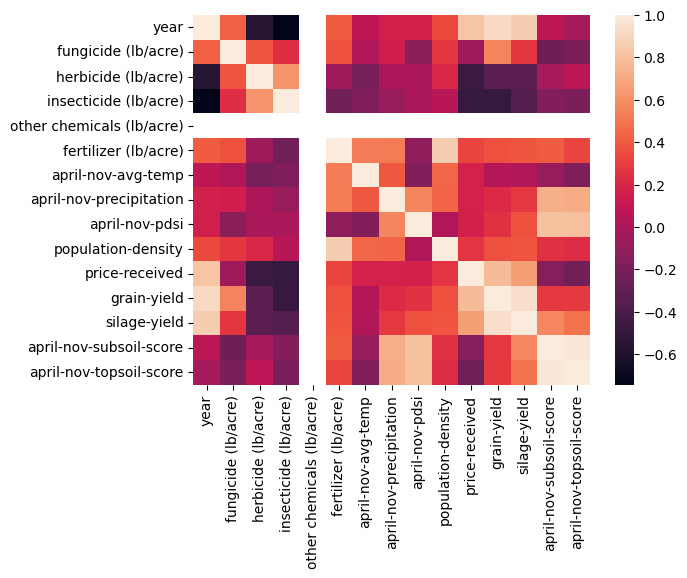

In [19]:
sns.heatmap(data=df_dirty_yearly.set_index('state').corr())
plt.show()

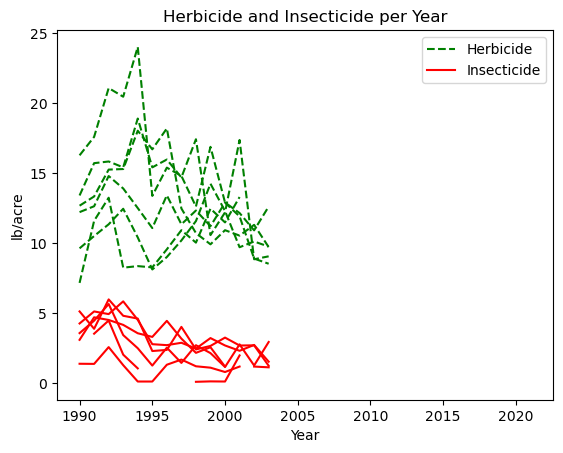

In [20]:
for state in states:
    plt.plot('year',
             'herbicide (lb/acre)',
              data=df_dirty_yearly[df_dirty_yearly['state'] == state],
              linestyle='--',
              color='g',
              label='Herbicide' if state == states[0] else ''
              )
for state in states:
    plt.plot('year', 'insecticide (lb/acre)',
             data=df_dirty_yearly[df_dirty_yearly['state'] == state],
             color='red',
             label='Insecticide' if state == states[0] else ''
             )
plt.title('Herbicide and Insecticide per Year')
plt.xlabel('Year')
plt.ylabel('lb/acre')
plt.legend()
plt.show()

In [21]:
df_dirty_yearly.drop(columns={'fungicide (lb/acre)', 'herbicide (lb/acre)', 'insecticide (lb/acre)', 'other chemicals (lb/acre)', 'fertilizer (lb/acre)'}, inplace=True)

df_yearly_1995 = df_dirty_yearly[df_dirty_yearly['year'] >= 1995]
df_yearly_1995.interpolate(inplace=True)
df_yearly_1995.interpolate(method='linear', limit_direction='forward', inplace=True)
df_yearly_1995.interpolate(method='linear', limit_direction='backward', inplace=True)

df_yearly_1919 = df_dirty_yearly[df_dirty_yearly['year'] >= 1919].drop(columns={'april-nov-subsoil-score', 'april-nov-topsoil-score'})
df_yearly_1919.interpolate(inplace=True)
df_yearly_1919.interpolate(method='linear', limit_direction='forward', inplace=True)
df_yearly_1919.interpolate(method='linear', limit_direction='backward', inplace=True)

/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/80359427.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_yearly_1995.interpolate(inplace=True)
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/80359427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly_1995.interpolate(inplace=True)
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/80359427.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_yearly_1995.interpolate(method='linear', limit_direction='forward', inplace=True)
/var/folders/j7/

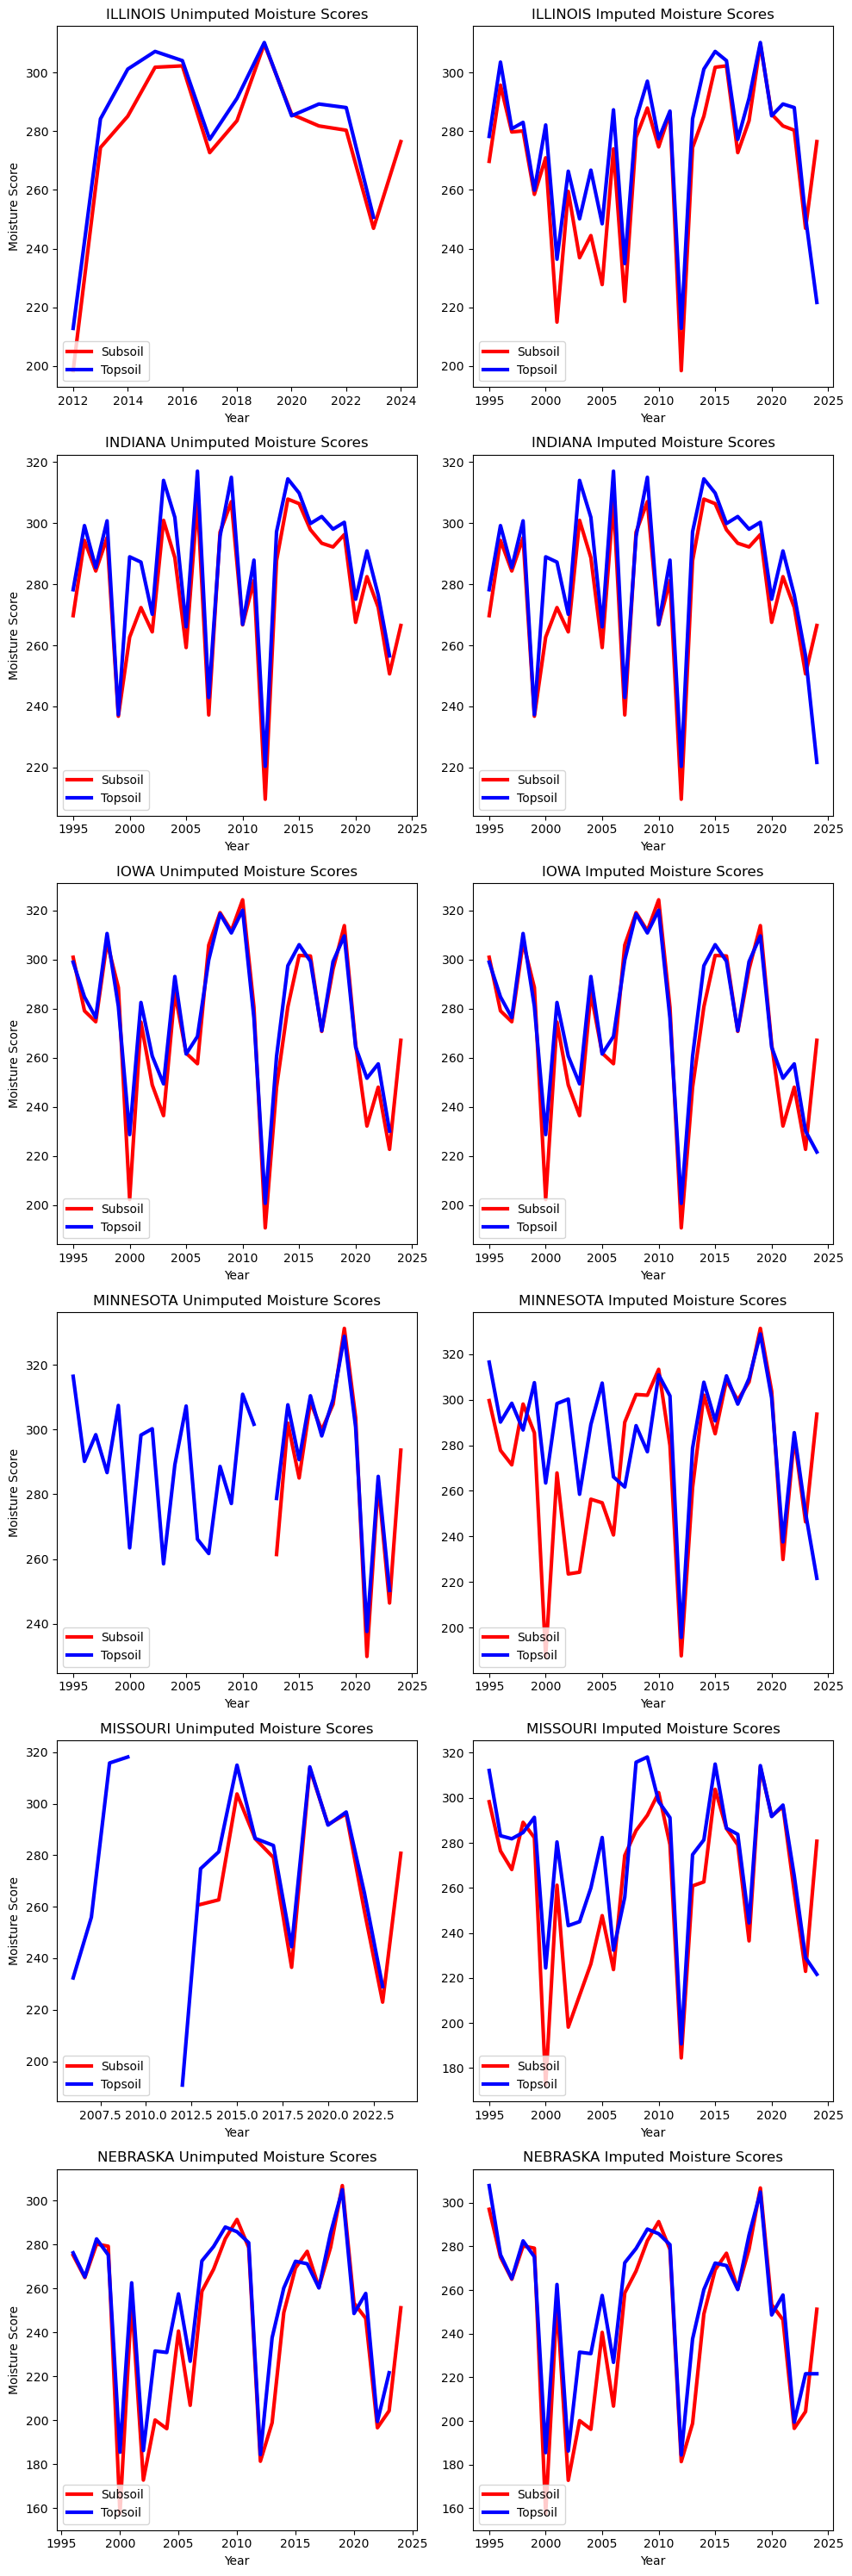

In [22]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 30))

for i, state in enumerate(states):
   
    axes[i][0].plot('year',
                 'april-nov-subsoil-score',
                 data=df_dirty_yearly[df_dirty_yearly['state'] == state],
                 color='red',
                 linewidth=3,
                 label='Subsoil')
    
    axes[i][0].plot('year',
                 'april-nov-topsoil-score',
                 data=df_dirty_yearly[df_dirty_yearly['state'] == state],
                 color='blue',
                 linewidth=3,
                 label='Topsoil')
    
    axes[i][1].plot('year',
                 'april-nov-subsoil-score',
                 data=df_yearly_1995[df_yearly_1995['state'] == state],
                 color='red',
                 linewidth=3,
                 label='Subsoil')
    
    axes[i][1].plot('year',
                 'april-nov-topsoil-score',
                 data=df_yearly_1995[df_yearly_1995['state'] == state],
                 color='blue',
                 linewidth=3,
                 label='Topsoil')
    
    axes[i][0].set_title(f'{state.upper()} Unimputed Moisture Scores')
    axes[i][0].set_ylabel('Moisture Score')
    axes[i][0].set_xlabel('Year')
    axes[i][0].legend(loc='lower left')

    axes[i][1].set_title(f'{state.upper()} Imputed Moisture Scores')
    axes[i][1].set_xlabel('Year')
    axes[i][1].legend(loc='lower left')

plt.xlabel('Year')
plt.tight_layout()
plt.savefig(f'../results/yearly-imputations.png')

### Monthly Variables

In [23]:
df_dirty_monthly = pd.read_csv('../data/all/processed/dirty-monthly.csv')

In [24]:
df_dirty_monthly.drop(columns={'fungicide (lb/acre)', 'herbicide (lb/acre)', 'insecticide (lb/acre)', 'other chemicals (lb/acre)', 'fertilizer (lb/acre)'}, inplace=True)

df_monthly_1995 = df_dirty_monthly[df_dirty_monthly['year'] >= 1995]
df_monthly_1995.interpolate(inplace=True)
df_monthly_1995.interpolate(method='linear', limit_direction='forward', inplace=True)
df_monthly_1995.interpolate(method='linear', limit_direction='backward', inplace=True)

df_monthly_1919 = df_dirty_monthly[df_dirty_monthly['year'] >= 1919]
for month in months:
    try:
        df_monthly_1919 = df_monthly_1919.drop(columns=[f'topsoil-score-{month}', f'subsoil-score-{month}'])
    except:
        print(f'{month} not found.')
df_monthly_1919.interpolate(inplace=True)
df_monthly_1919.interpolate(method='linear', limit_direction='forward', inplace=True)
df_monthly_1919.interpolate(method='linear', limit_direction='backward', inplace=True)

november not found.


/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/1809034218.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_monthly_1995.interpolate(inplace=True)
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/1809034218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_1995.interpolate(inplace=True)
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/1809034218.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_monthly_1995.interpolate(method='linear', limit_direction='forward', inplace=True)
/var/fo

november not found.
november not found.
november not found.
november not found.
november not found.
november not found.


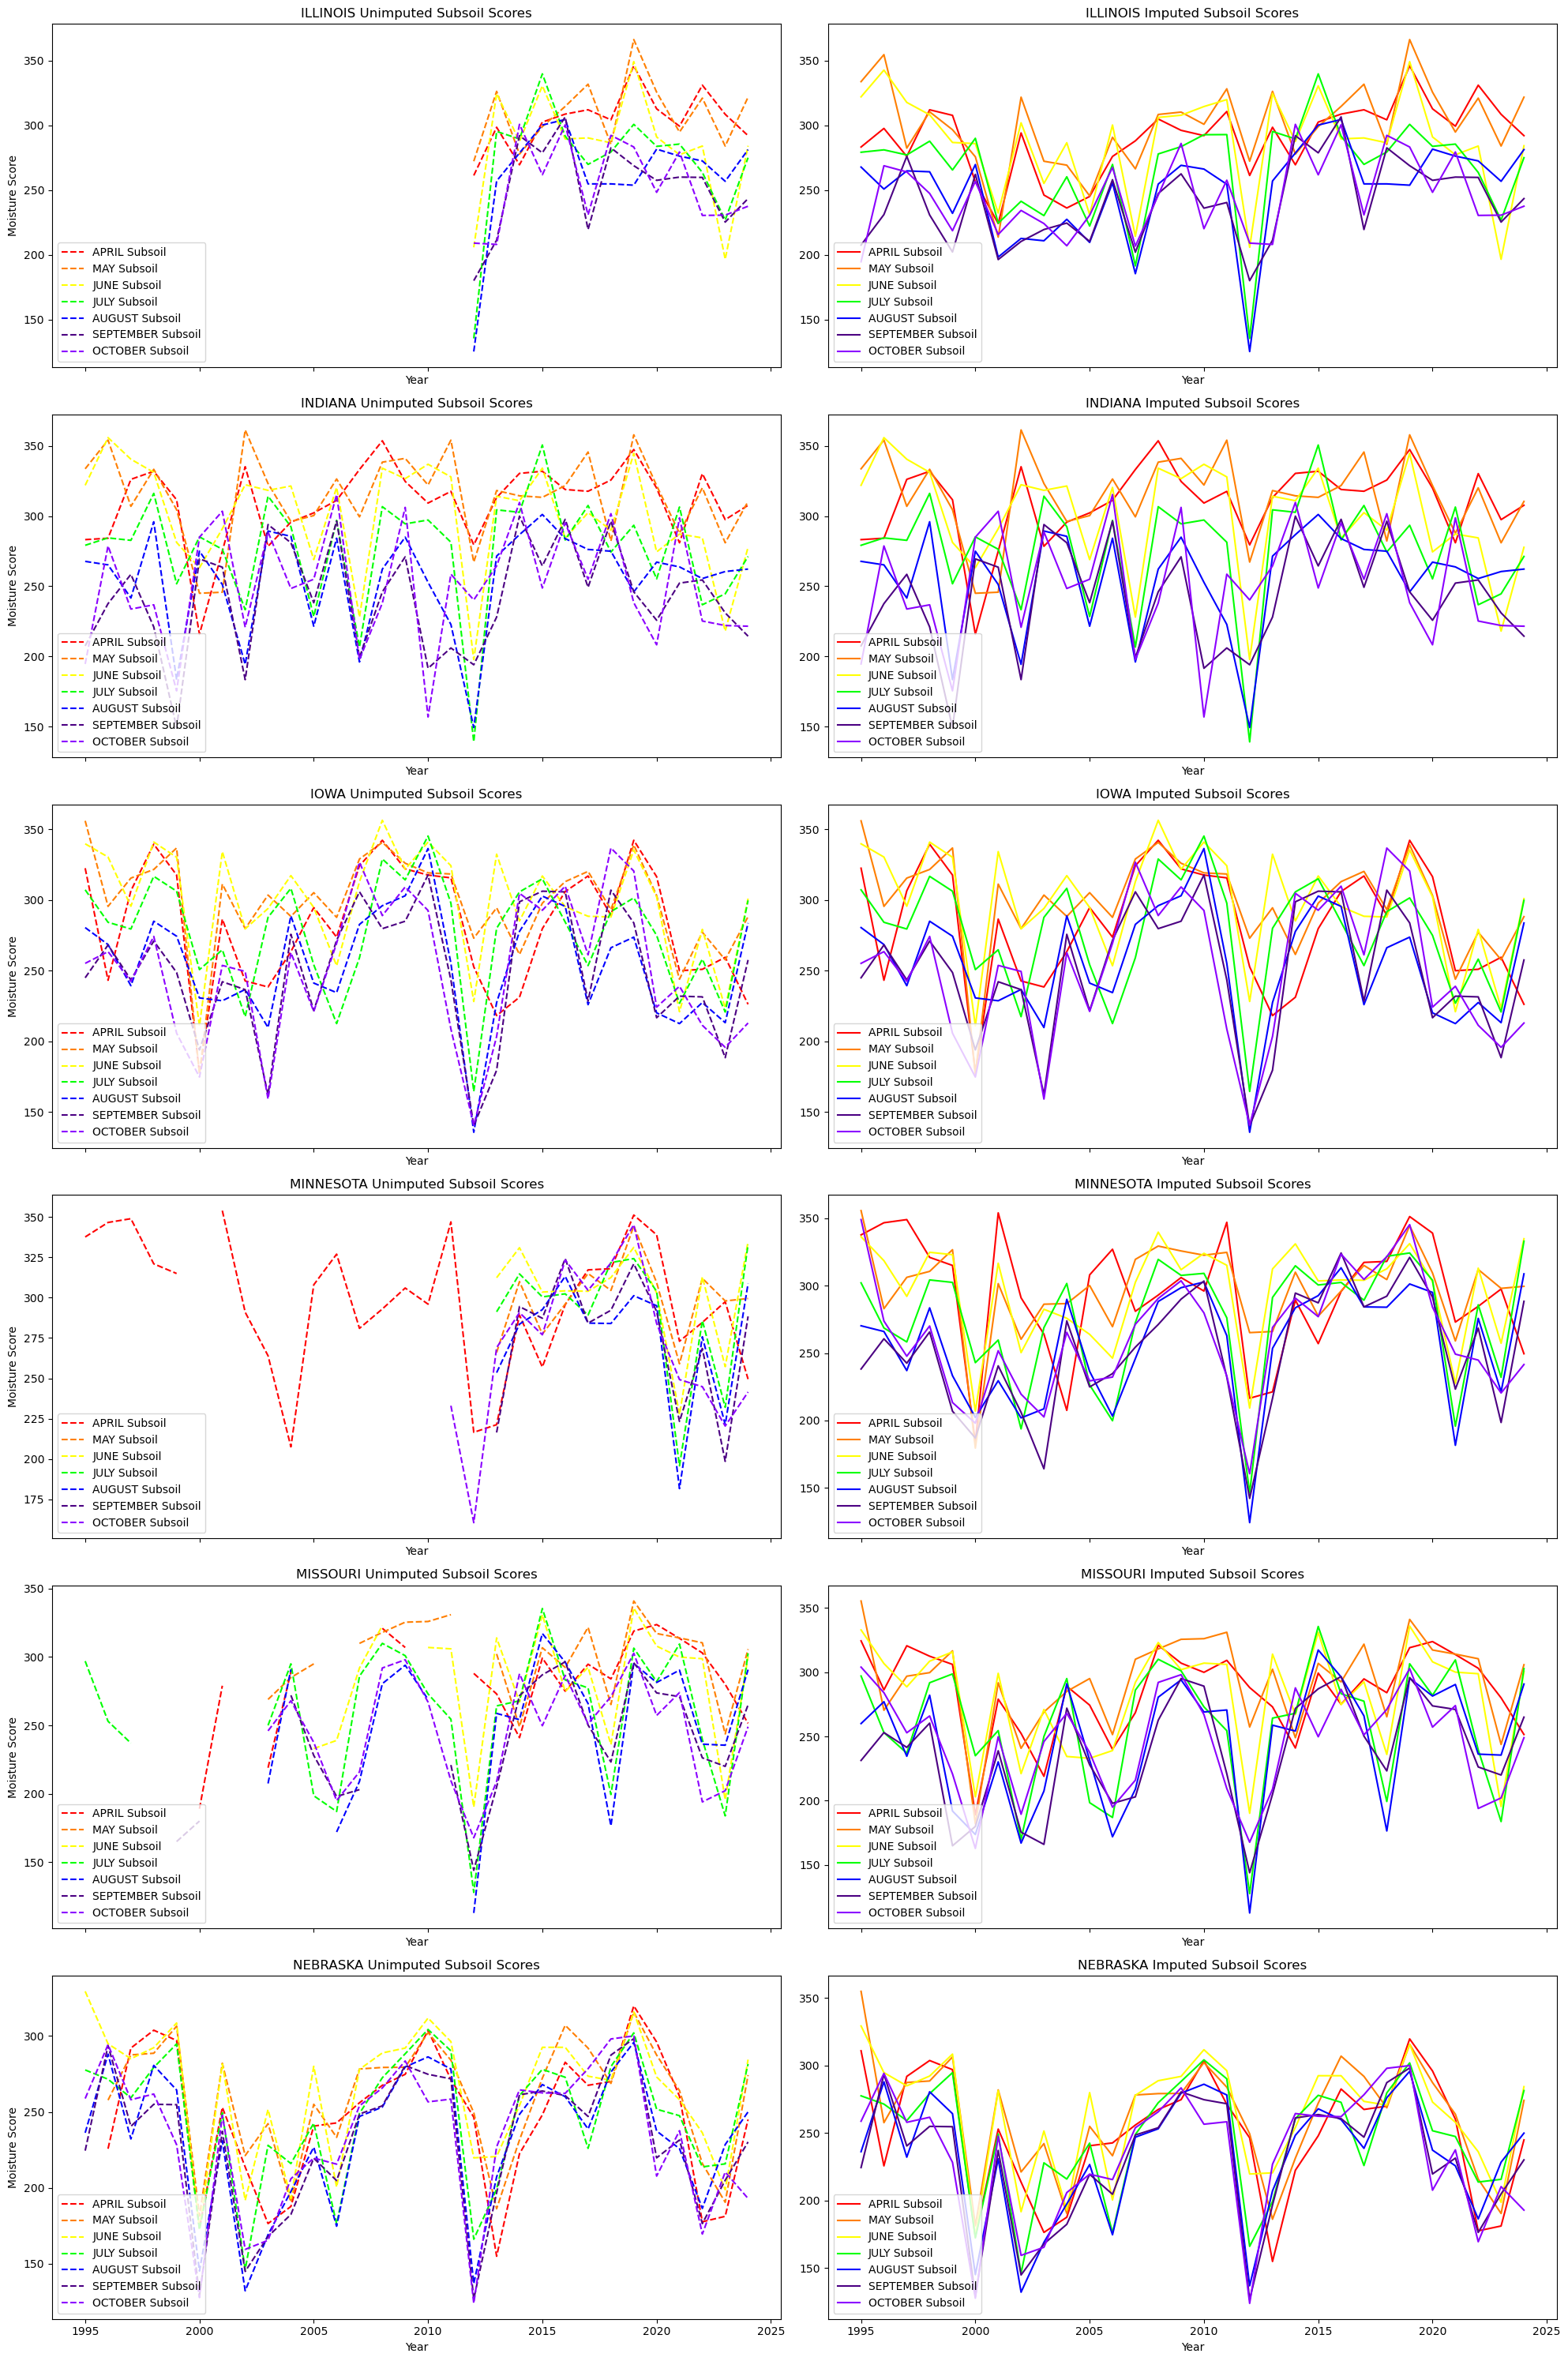

In [25]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#FF4500']

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 30), sharex=True)

for i, state in enumerate(states):
    
    for j, month in enumerate(months):

        try:
            if df_monthly[f'subsoil-score-{month}'].isna().sum() > 0:

                axes[i][0].plot('year',
                                f'subsoil-score-{month}',
                                data=df_monthly[df_monthly['state'] == state],
                                linestyle='--',
                                color=colors[j],
                                label=f'{month.upper()} Subsoil')

                axes[i][1].plot('year',
                                f'subsoil-score-{month}',
                                data=df_monthly_1995[df_monthly_1995['state'] == state],
                                color=colors[j],
                                label=f'{month.upper()} Subsoil')
        except:
            print(f'{month} not found.')
    
    axes[i][0].set_title(f'{state.upper()} Unimputed Subsoil Scores')
    axes[i][0].set_ylabel('Moisture Score')
    axes[i][0].set_xlabel('Year')
    axes[i][0].legend(loc='lower left')

    axes[i][1].set_title(f'{state.upper()} Imputed Subsoil Scores')
    axes[i][1].set_xlabel('Year')
    axes[i][1].legend(loc='lower left')

plt.xlabel('Year')
plt.tight_layout()
plt.savefig(f'../results/monthly-imputations.png')

In [26]:
dfs = [df_monthly_1919, df_monthly_1995, df_yearly_1919, df_yearly_1995]
dfs_names = ['df_monthly_1919', 'df_monthly_1995', 'df_yearly_1919', 'df_yearly_1995']

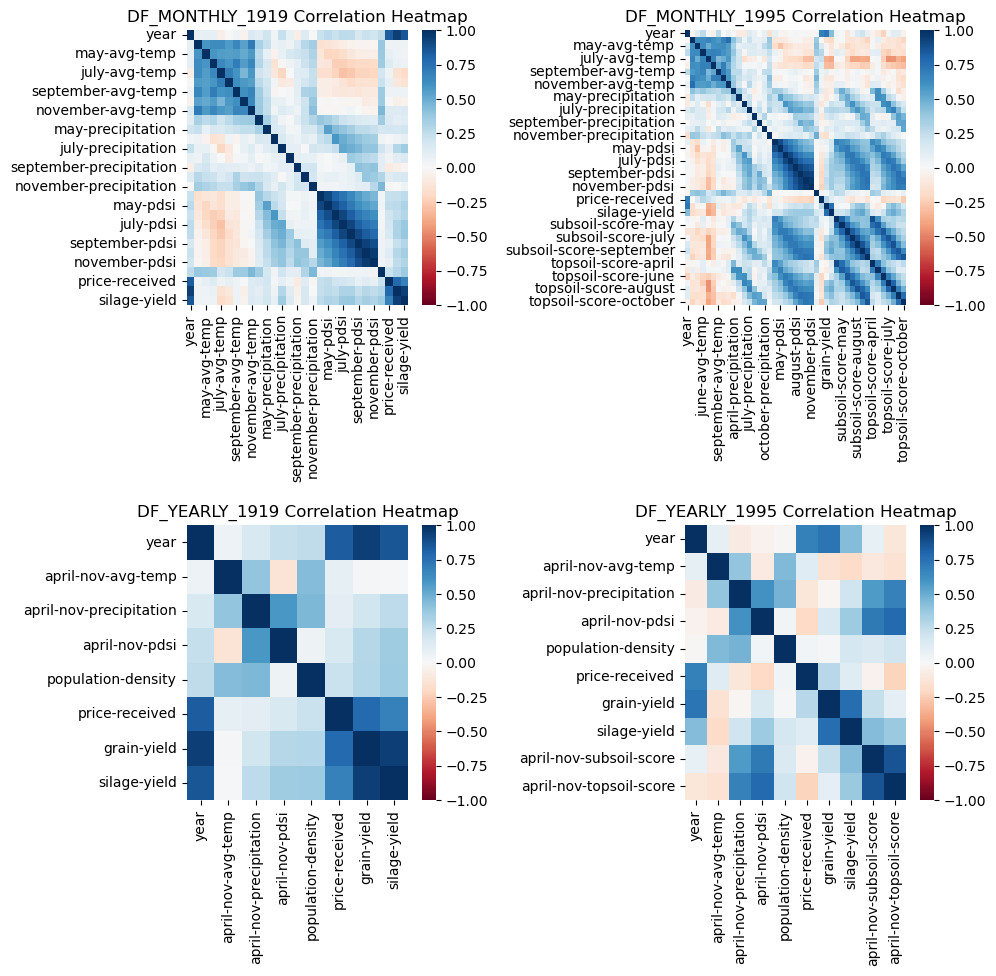

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, df in enumerate(dfs):
    row, col = divmod(i, 2)
    sns.heatmap(data=df.drop(columns='state').corr(), cmap='RdBu', vmin=-1, vmax=1, ax=axes[row][col])
    axes[row][col].set_title(f'{dfs_names[i].upper()} Correlation Heatmap')

plt.subplots_adjust(wspace=0.8, hspace=0.8)

In [28]:
data_df = []

data_variable1 = []
data_variable2 = []

data_pearson = []
data_pearson_p = []

data_spearman = []
data_spearman_p = []

data_kendalltau = []
data_kendalltau_p = []

fig = plt.figure()

for i, df in enumerate(dfs):

    for col1, col2 in itertools.combinations(df.columns[2:], 2):

        array1 = df[col1].to_numpy()
        array2 = df[col2].to_numpy()
        pearson, pearson_p = scipy.stats.pearsonr(array1, array2)
        spearman, spearman_p = scipy.stats.spearmanr(array1, array2)
        kendalltau, kendalltau_p = scipy.stats.kendalltau(array1, array2)        

        data_df.append(dfs_names[i])

        data_variable1.append(col1)
        data_variable2.append(col2)

        data_pearson.append(pearson)
        data_pearson_p.append(pearson_p)

        data_spearman.append(spearman)
        data_spearman_p.append(spearman_p)

        data_kendalltau.append(kendalltau)
        data_kendalltau_p.append(kendalltau_p)

df_corr = pd.DataFrame({

    'df':data_df,

    'variable1':data_variable1,
    'variable2':data_variable2,

    'pearson':data_pearson,
    'p-pearson':data_pearson_p,

    'spearman':data_spearman,
    'p-spearman':data_spearman_p,

    'kendalltau':data_kendalltau,
    'p-kendalltau':data_kendalltau_p

    })

<Figure size 640x480 with 0 Axes>

### Scatterplots

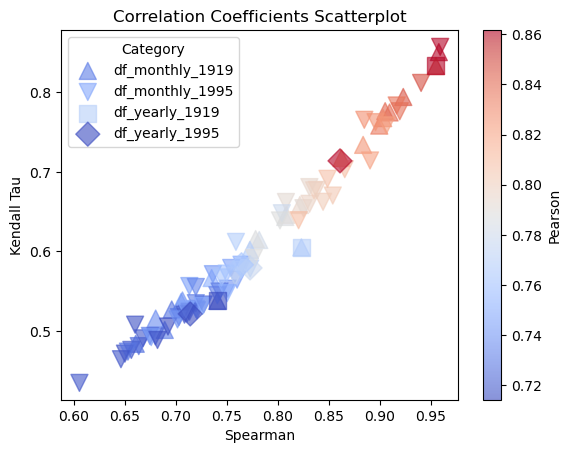

(93, 9)


df       variable1      variable2   pearson      p-pearson  \
0  df_monthly_1995    october-pdsi  november-pdsi  0.967192  7.332860e-108   
1  df_monthly_1919    october-pdsi  november-pdsi  0.959468   0.000000e+00   
2  df_monthly_1995  september-pdsi   october-pdsi  0.942615   1.001572e-86   
3   df_yearly_1919     grain-yield   silage-yield  0.940450  2.696730e-299   
4  df_monthly_1919     grain-yield   silage-yield  0.940450  2.696730e-299   

   spearman     p-spearman  kendalltau   p-kendalltau  
0  0.959458  7.900079e-100    0.856796   3.834083e-65  
1  0.958138   0.000000e+00    0.850310  2.790201e-225  
2  0.940742   1.605871e-85    0.811563   1.433885e-58  
3  0.955307   0.000000e+00    0.832873  2.314542e-211  
4  0.955307   0.000000e+00    0.832873  2.314542e-211

In [29]:
category_markers = {
    'df_monthly_1919':'^',
    'df_monthly_1995':'v',
    'df_yearly_1919':'s',
    'df_yearly_1995':'D'
}

handles = []

df = df_corr[
    ((df_corr['pearson'] >= 0.7) & (df_corr['p-pearson'] <= 0.05)) |
    ((df_corr['spearman'] >= 0.7) & (df_corr['p-spearman'] <= 0.05)) |
    ((df_corr['kendalltau'] >= 0.7) & (df_corr['p-kendalltau'] <= 0.05))
    ]

for category, marker in category_markers.items():

    subset = df[df['df'] == category]
    scatterplot = plt.scatter(
        subset['spearman'],
        subset['kendalltau'],
        c=subset['pearson'],
        cmap='coolwarm',
        s=150,
        marker=marker,
        alpha=0.6,label=marker
        )
    handles.append(scatterplot)
    
plt.colorbar(label='Pearson')

plt.legend(
    handles=handles,
    labels=['df_monthly_1919', 'df_monthly_1995', 'df_yearly_1919', 'df_yearly_1995'],
    title='Category'
    )

plt.xlabel('Spearman')
plt.ylabel('Kendall Tau')

plt.title('Correlation Coefficients Scatterplot')

plt.show()
print(df.shape)
df = df.sort_values(by='pearson', ascending=False, ignore_index=True)
df.head()

In [30]:
df_nan_plot = df_dirty_monthly[['year', 'state', 'grain-yield', 'price-received']].copy()
for index, data in df_nan_plot.iterrows():
    df_nan_plot['nan'] = 0
    if df_nan_plot.isna().loc[index]['price-received'] == True:
        df_nan_plot.loc[index]['nan'] = 1

/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/2005111876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan_plot.loc[index]['nan'] = 1


In [31]:
df_nan_plot[df_nan_plot['nan'] == 1]

Empty DataFrame
Columns: [year, state, grain-yield, price-received, nan]
Index: []

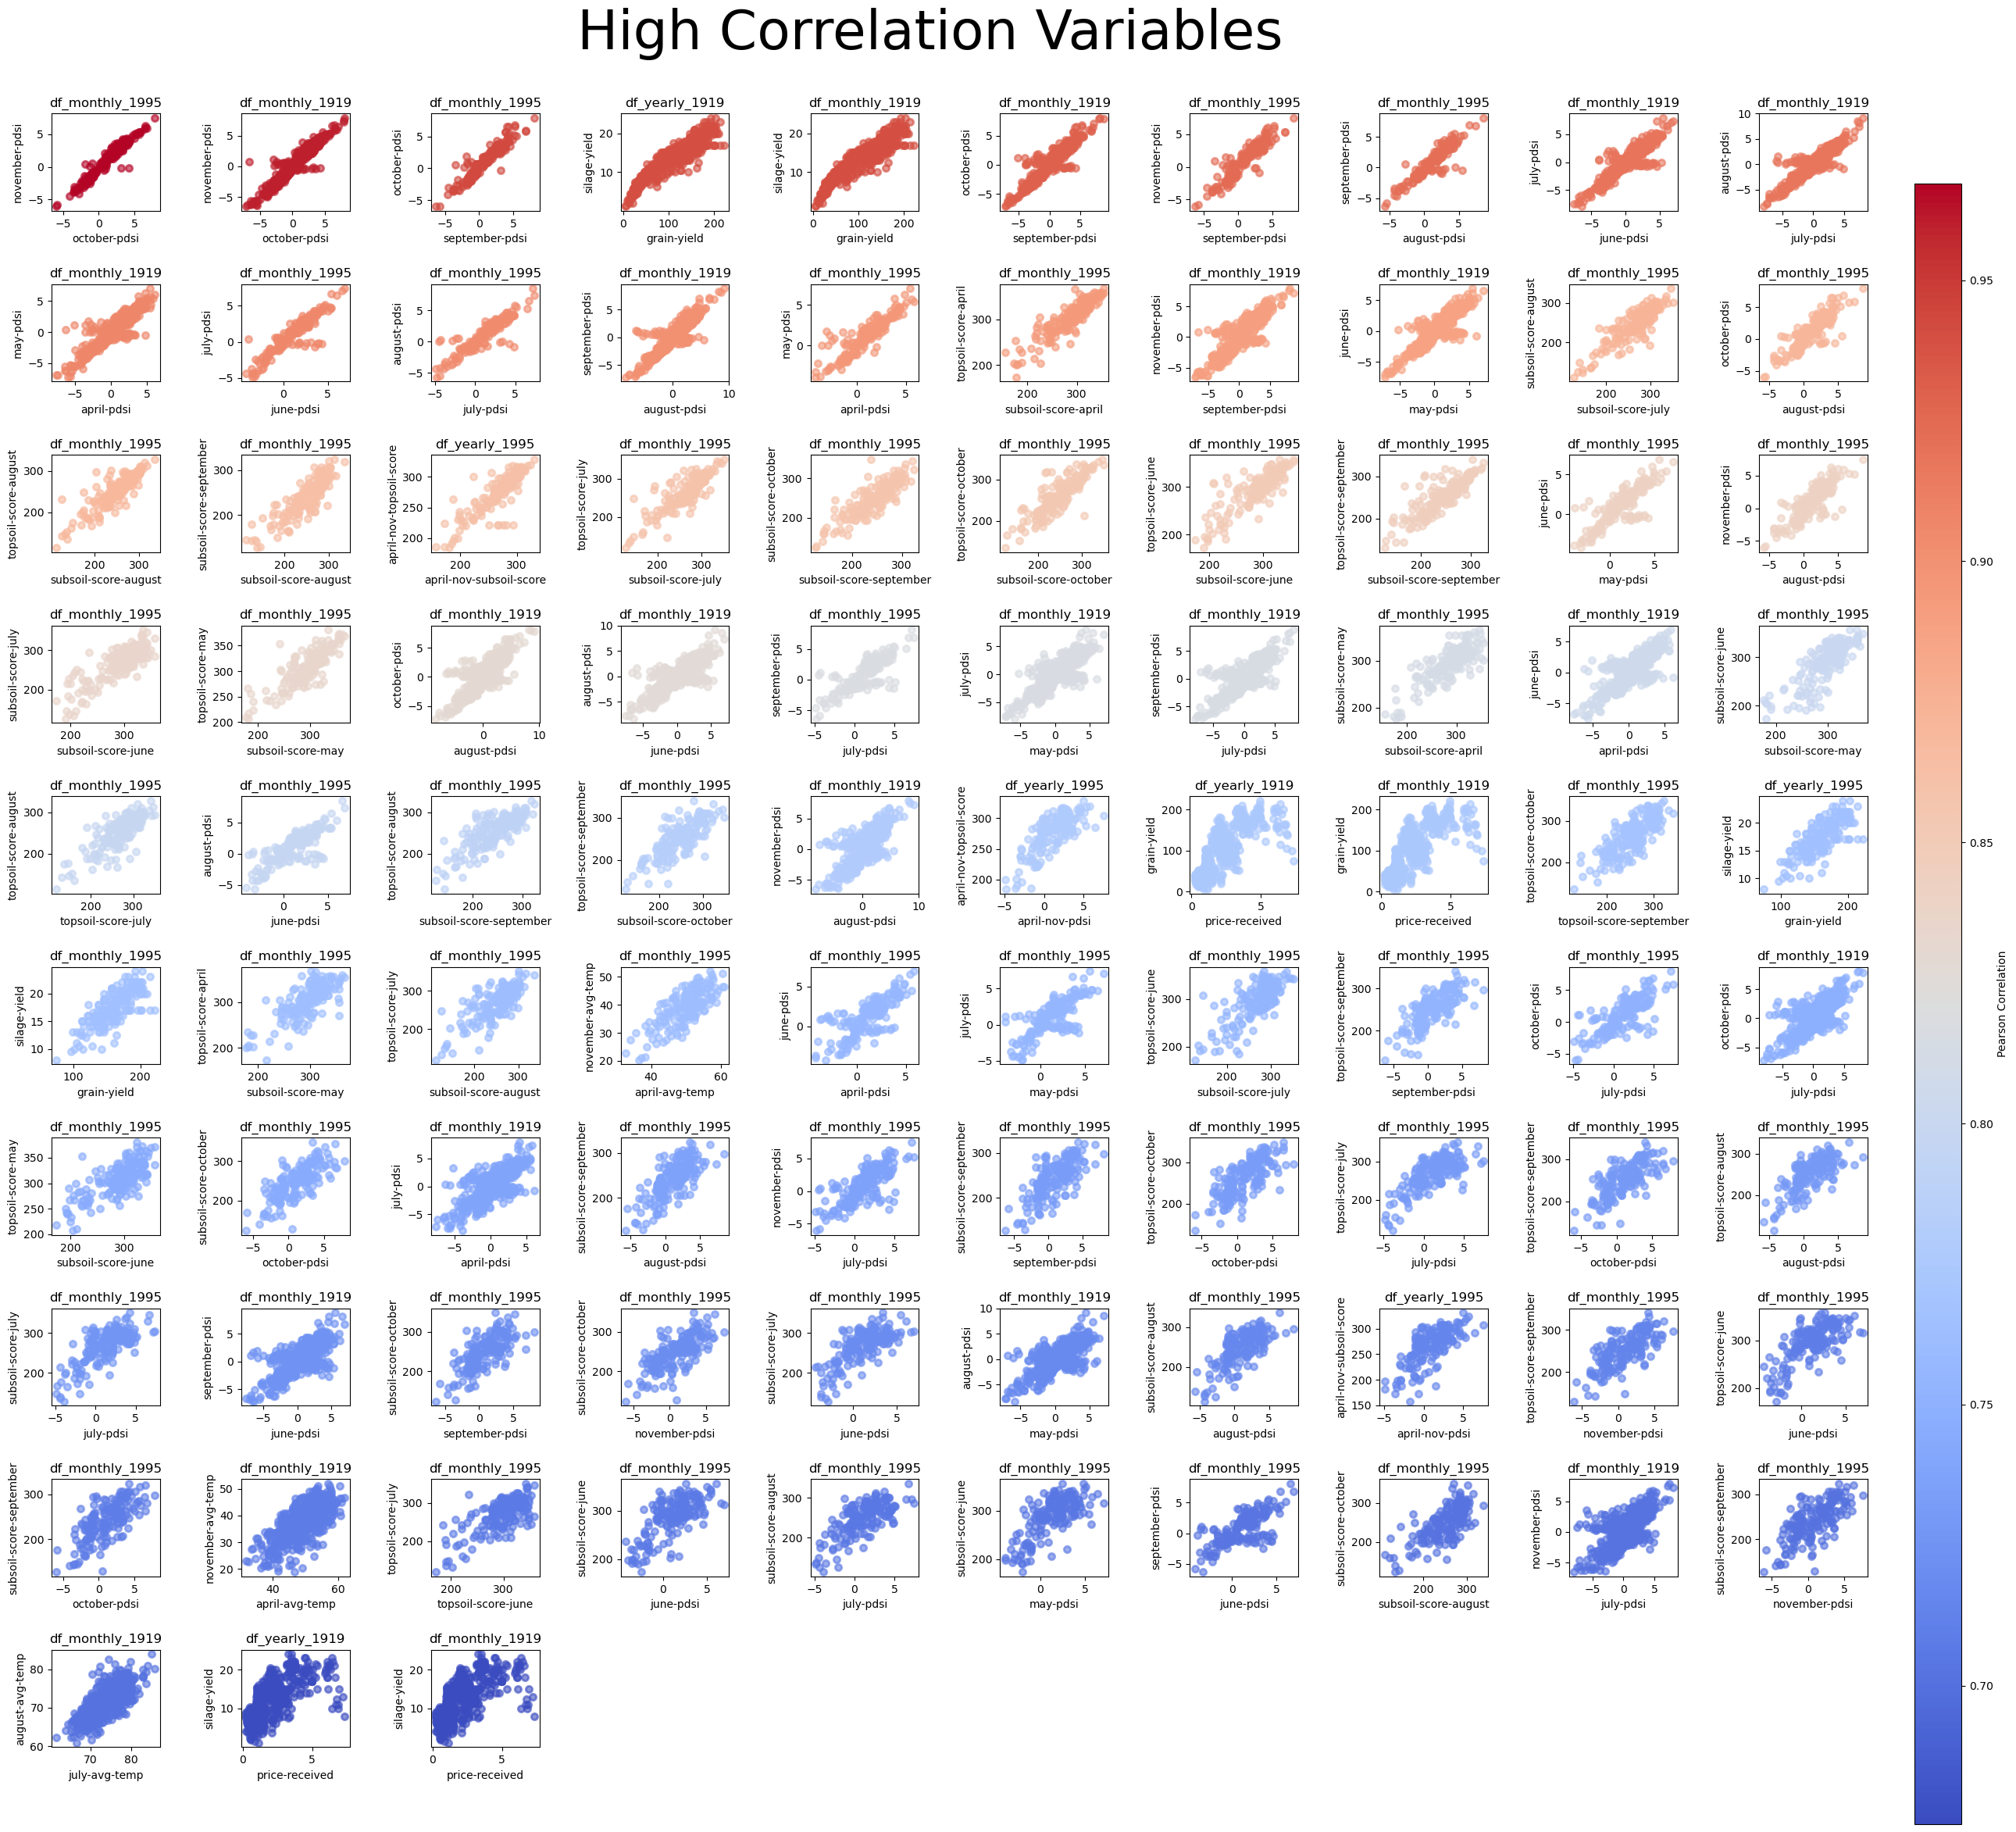

In [32]:
fig = plt.figure()

norm = plt.Normalize(df['pearson'].min(), df['pearson'].max())
cmap = cm.coolwarm

for i, row in df.iterrows():

    if df.iat[i, 0] == 'df_monthly_1919':
        df_temp = df_monthly_1919
        graph_title = dfs_names[0]

    elif df.iat[i, 0] == 'df_monthly_1995':
        df_temp = df_monthly_1995
        graph_title = dfs_names[1]

    elif df.iat[i, 0] == 'df_yearly_1919':
        df_temp = df_yearly_1919
        graph_title = dfs_names[2]

    elif df.iat[i, 0] == 'df_yearly_1995':
        df_temp = df_yearly_1995
        graph_title = dfs_names[3]

    plt.subplot(11, 10, i+1)

    col1 = df.iat[i, 1]
    col2 = df.iat[i, 2]

    color_value = cmap(norm(df.iat[i, 3]))

    plt.scatter(
        df_temp[col1],
        df_temp[col2],
        c=[color_value],
        linewidths=2,
        alpha=0.6
        )
    
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(graph_title)

fig.set_figheight(30)
fig.set_figwidth(30)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='vertical', label='Pearson Correlation')

plt.subplots_adjust(wspace=0.75, hspace=0.75)

plt.suptitle('High Correlation Variables', fontsize=50, x=0.5, y=0.925)

fig.savefig('../results/high-correlation-variables.png')

## Making Lagged Variables

In [33]:
## df_monthly_1919
vars = [
    'april-avg-temp', 'may-avg-temp', 'june-avg-temp', 'july-avg-temp', 'august-avg-temp', 'september-avg-temp',
    'october-avg-temp', 'november-avg-temp', 'april-precipitation', 'may-precipitation', 'june-precipitation',
    'july-precipitation', 'august-precipitation', 'september-precipitation', 'october-precipitation', 
    'november-precipitation', 'april-pdsi', 'may-pdsi', 'june-pdsi', 'july-pdsi', 'august-pdsi', 
    'september-pdsi', 'october-pdsi', 'november-pdsi', 'price-received', 'silage-yield', 'grain-yield'
]

states = ['illinois', 'indiana', 'iowa', 'minnesota', 'missouri', 'nebraska']

df_copy = df_monthly_1919.copy()

for state in states:

    df_state = df_copy[df_copy['state'] == state].copy()
    
    for var in vars:
        df_copy.loc[df_state.index, f'{var}-lagged'] = df_state[var].shift(-1)

df_copy.drop(columns=vars[:-1], inplace=True)

df_copy.interpolate(method='linear', limit_direction='forward', inplace=True)
df_copy.interpolate(method='linear', limit_direction='backward', inplace=True)

df_monthly_1919_lag = df_copy


## df_monthly_1995
vars = [
    'april-avg-temp', 'may-avg-temp', 'june-avg-temp', 'july-avg-temp', 'august-avg-temp', 'september-avg-temp',
    'october-avg-temp', 'november-avg-temp', 'april-precipitation', 'may-precipitation', 'june-precipitation',
    'july-precipitation', 'august-precipitation', 'september-precipitation', 'october-precipitation', 
    'november-precipitation', 'april-pdsi', 'may-pdsi', 'june-pdsi', 'july-pdsi', 'august-pdsi', 
    'september-pdsi', 'october-pdsi', 'november-pdsi', 'price-received', 'silage-yield',
    'subsoil-score-april', 'subsoil-score-may', 'subsoil-score-june', 'subsoil-score-july',
    'subsoil-score-august', 'subsoil-score-september', 'subsoil-score-october', 'topsoil-score-april',
    'topsoil-score-may', 'topsoil-score-june', 'topsoil-score-july', 'topsoil-score-august',
    'topsoil-score-september', 'topsoil-score-october', 'grain-yield'
]

states = ['illinois', 'indiana', 'iowa', 'minnesota', 'missouri', 'nebraska']

df_copy = df_monthly_1995.copy()

for state in states:

    df_state = df_copy[df_copy['state'] == state].copy()
    
    for var in vars:
        df_copy.loc[df_state.index, f'{var}-lagged'] = df_state[var].shift(-1)

df_copy.drop(columns=vars[:-1], inplace=True)

df_copy.interpolate(method='linear', limit_direction='forward', inplace=True)
df_copy.interpolate(method='linear', limit_direction='backward', inplace=True)

df_monthly_1995_lag = df_copy


## df_yearly_1919
vars = [
    'april-nov-avg-temp', 'april-nov-precipitation', 'april-nov-pdsi', 'silage-yield', 'grain-yield'
]

states = ['illinois', 'indiana', 'iowa', 'minnesota', 'missouri', 'nebraska']

df_copy = df_yearly_1919.copy()

for state in states:

    df_state = df_copy[df_copy['state'] == state].copy()
    
    for var in vars:
        df_copy.loc[df_state.index, f'{var}-lagged'] = df_state[var].shift(-1)

df_copy.drop(columns=vars[:-1], inplace=True)

df_copy.interpolate(method='linear', limit_direction='forward', inplace=True)
df_copy.interpolate(method='linear', limit_direction='backward', inplace=True)

df_yearly_1919_lag = df_copy


## df_yearly_1995
vars = [
    'april-nov-avg-temp', 'april-nov-precipitation', 'april-nov-pdsi',
    'april-nov-subsoil-score', 'april-nov-topsoil-score', 'silage-yield', 'grain-yield'
]

states = ['illinois', 'indiana', 'iowa', 'minnesota', 'missouri', 'nebraska']

df_copy = df_yearly_1995.copy()

for state in states:

    df_state = df_copy[df_copy['state'] == state].copy()
    
    for var in vars:
        df_copy.loc[df_state.index, f'{var}-lagged'] = df_state[var].shift(-1)

df_copy.drop(columns=vars[:-1], inplace=True)

df_copy.interpolate(method='linear', limit_direction='forward', inplace=True)
df_copy.interpolate(method='linear', limit_direction='backward', inplace=True)

df_yearly_1995_lag = df_copy

/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/1609611903.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_copy.interpolate(method='linear', limit_direction='forward', inplace=True)
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/1609611903.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_copy.interpolate(method='linear', limit_direction='backward', inplace=True)
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/1609611903.py:55: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_copy.interpolate(method='linear', limit_direction='forward', inplace=True)


In [34]:
df_monthly_1919_lag.drop(columns=['population-density', 'grain-yield'], inplace=True)
df_yearly_1919.drop(columns=['population-density', 'price-received', 'grain-yield', 'silage-yield'], inplace=True)
df_yearly_1919_lag.drop(columns=['population-density', 'price-received', 'grain-yield', 'silage-yield-lagged', 'grain-yield-lagged'], inplace=True)

df_19 = df_monthly_1919.merge(
    df_monthly_1919_lag,
    on=['year', 'state'],
    how='outer'
)
df_19 = df_19.merge(
    df_yearly_1919,
    on=['year', 'state'],
    how='outer'
)
df_19 = df_19.merge(
    df_yearly_1919_lag,
    on=['year', 'state'],
    how='outer'
)

df_19.to_csv('../data/final/1919.csv', index=False)


df_monthly_1995_lag.drop(columns=['population-density', 'grain-yield'], inplace=True)
df_yearly_1995.drop(columns=['population-density', 'price-received', 'grain-yield', 'silage-yield'], inplace=True)
df_yearly_1995_lag.drop(columns=['population-density', 'price-received', 'grain-yield', 'silage-yield-lagged', 'grain-yield-lagged'], inplace=True)

df_95 = df_monthly_1995.merge(
    df_monthly_1919_lag,
    on=['year', 'state'],
    how='outer'
)
df_95 = df_95.merge(
    df_yearly_1995,
    on=['year', 'state'],
    how='outer'
)
df_95 = df_95.merge(
    df_yearly_1995_lag,
    on=['year', 'state'],
    how='outer'
)

df_95.to_csv('../data/final/1995.csv', index=False)

/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_29456/3598318678.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly_1995.drop(columns=['population-density', 'price-received', 'grain-yield', 'silage-yield'], inplace=True)


## Boxplots, Histograms, & Heatmap

<Figure size 640x480 with 0 Axes>

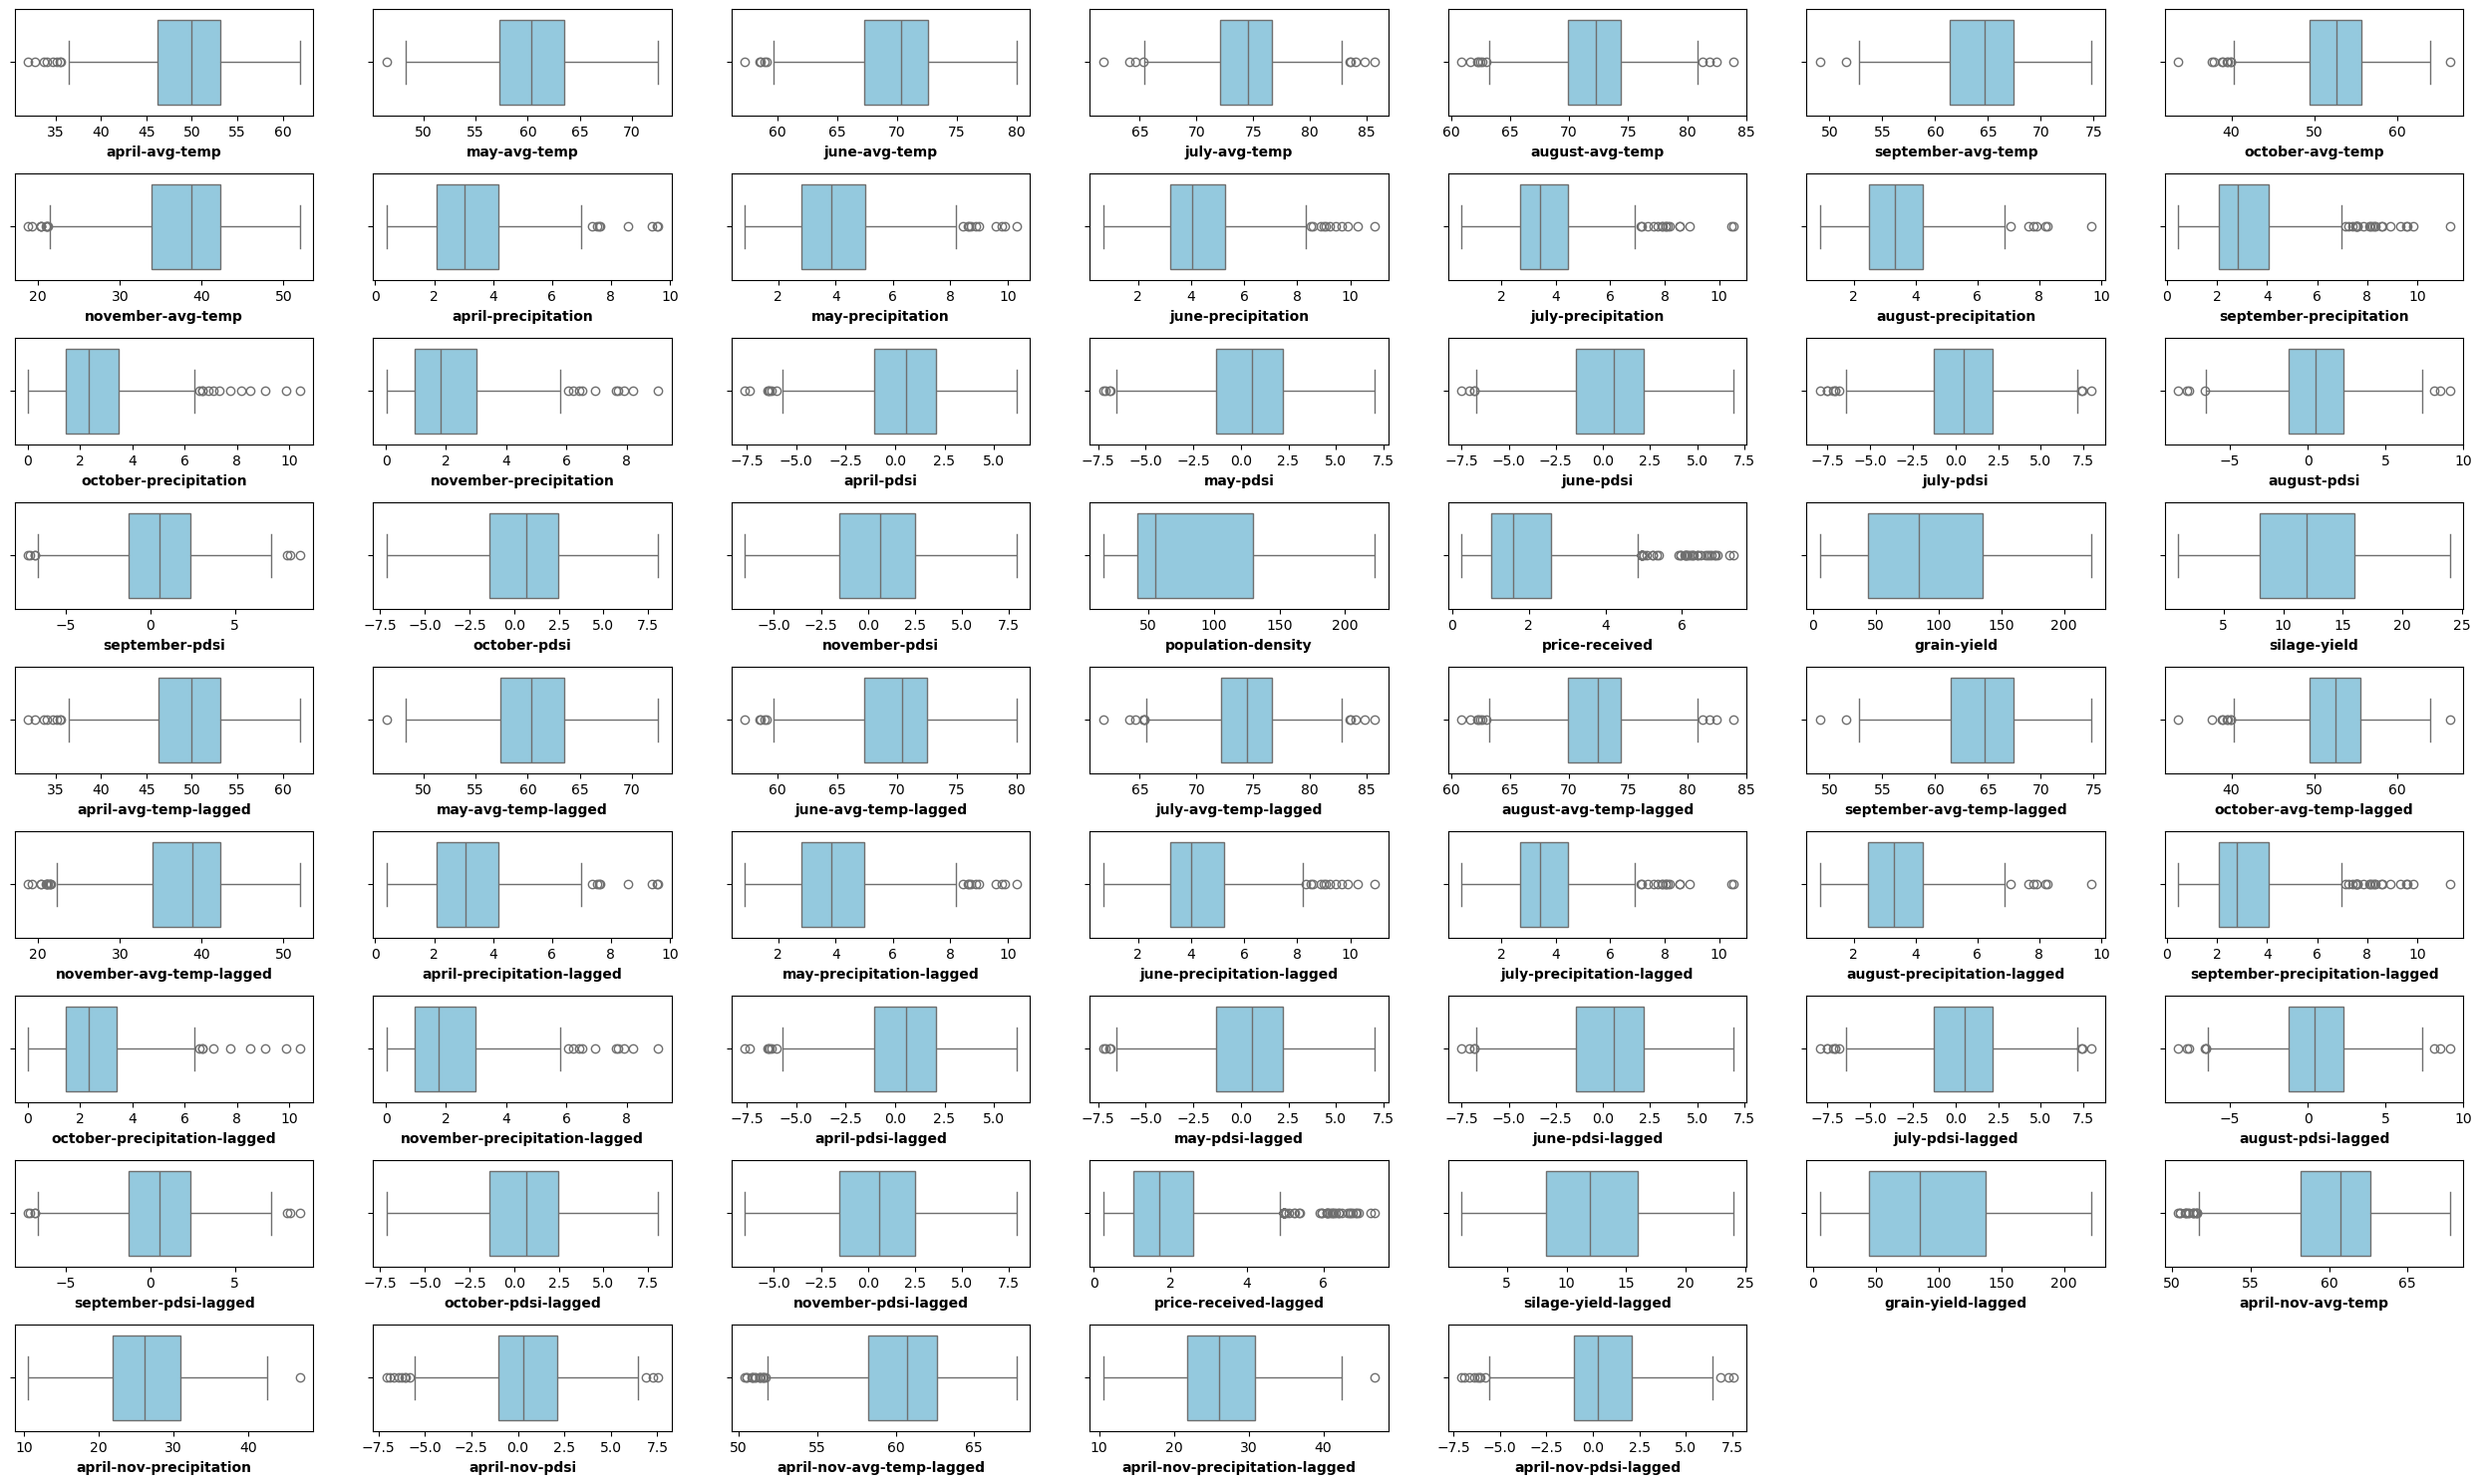

<Figure size 640x480 with 0 Axes>

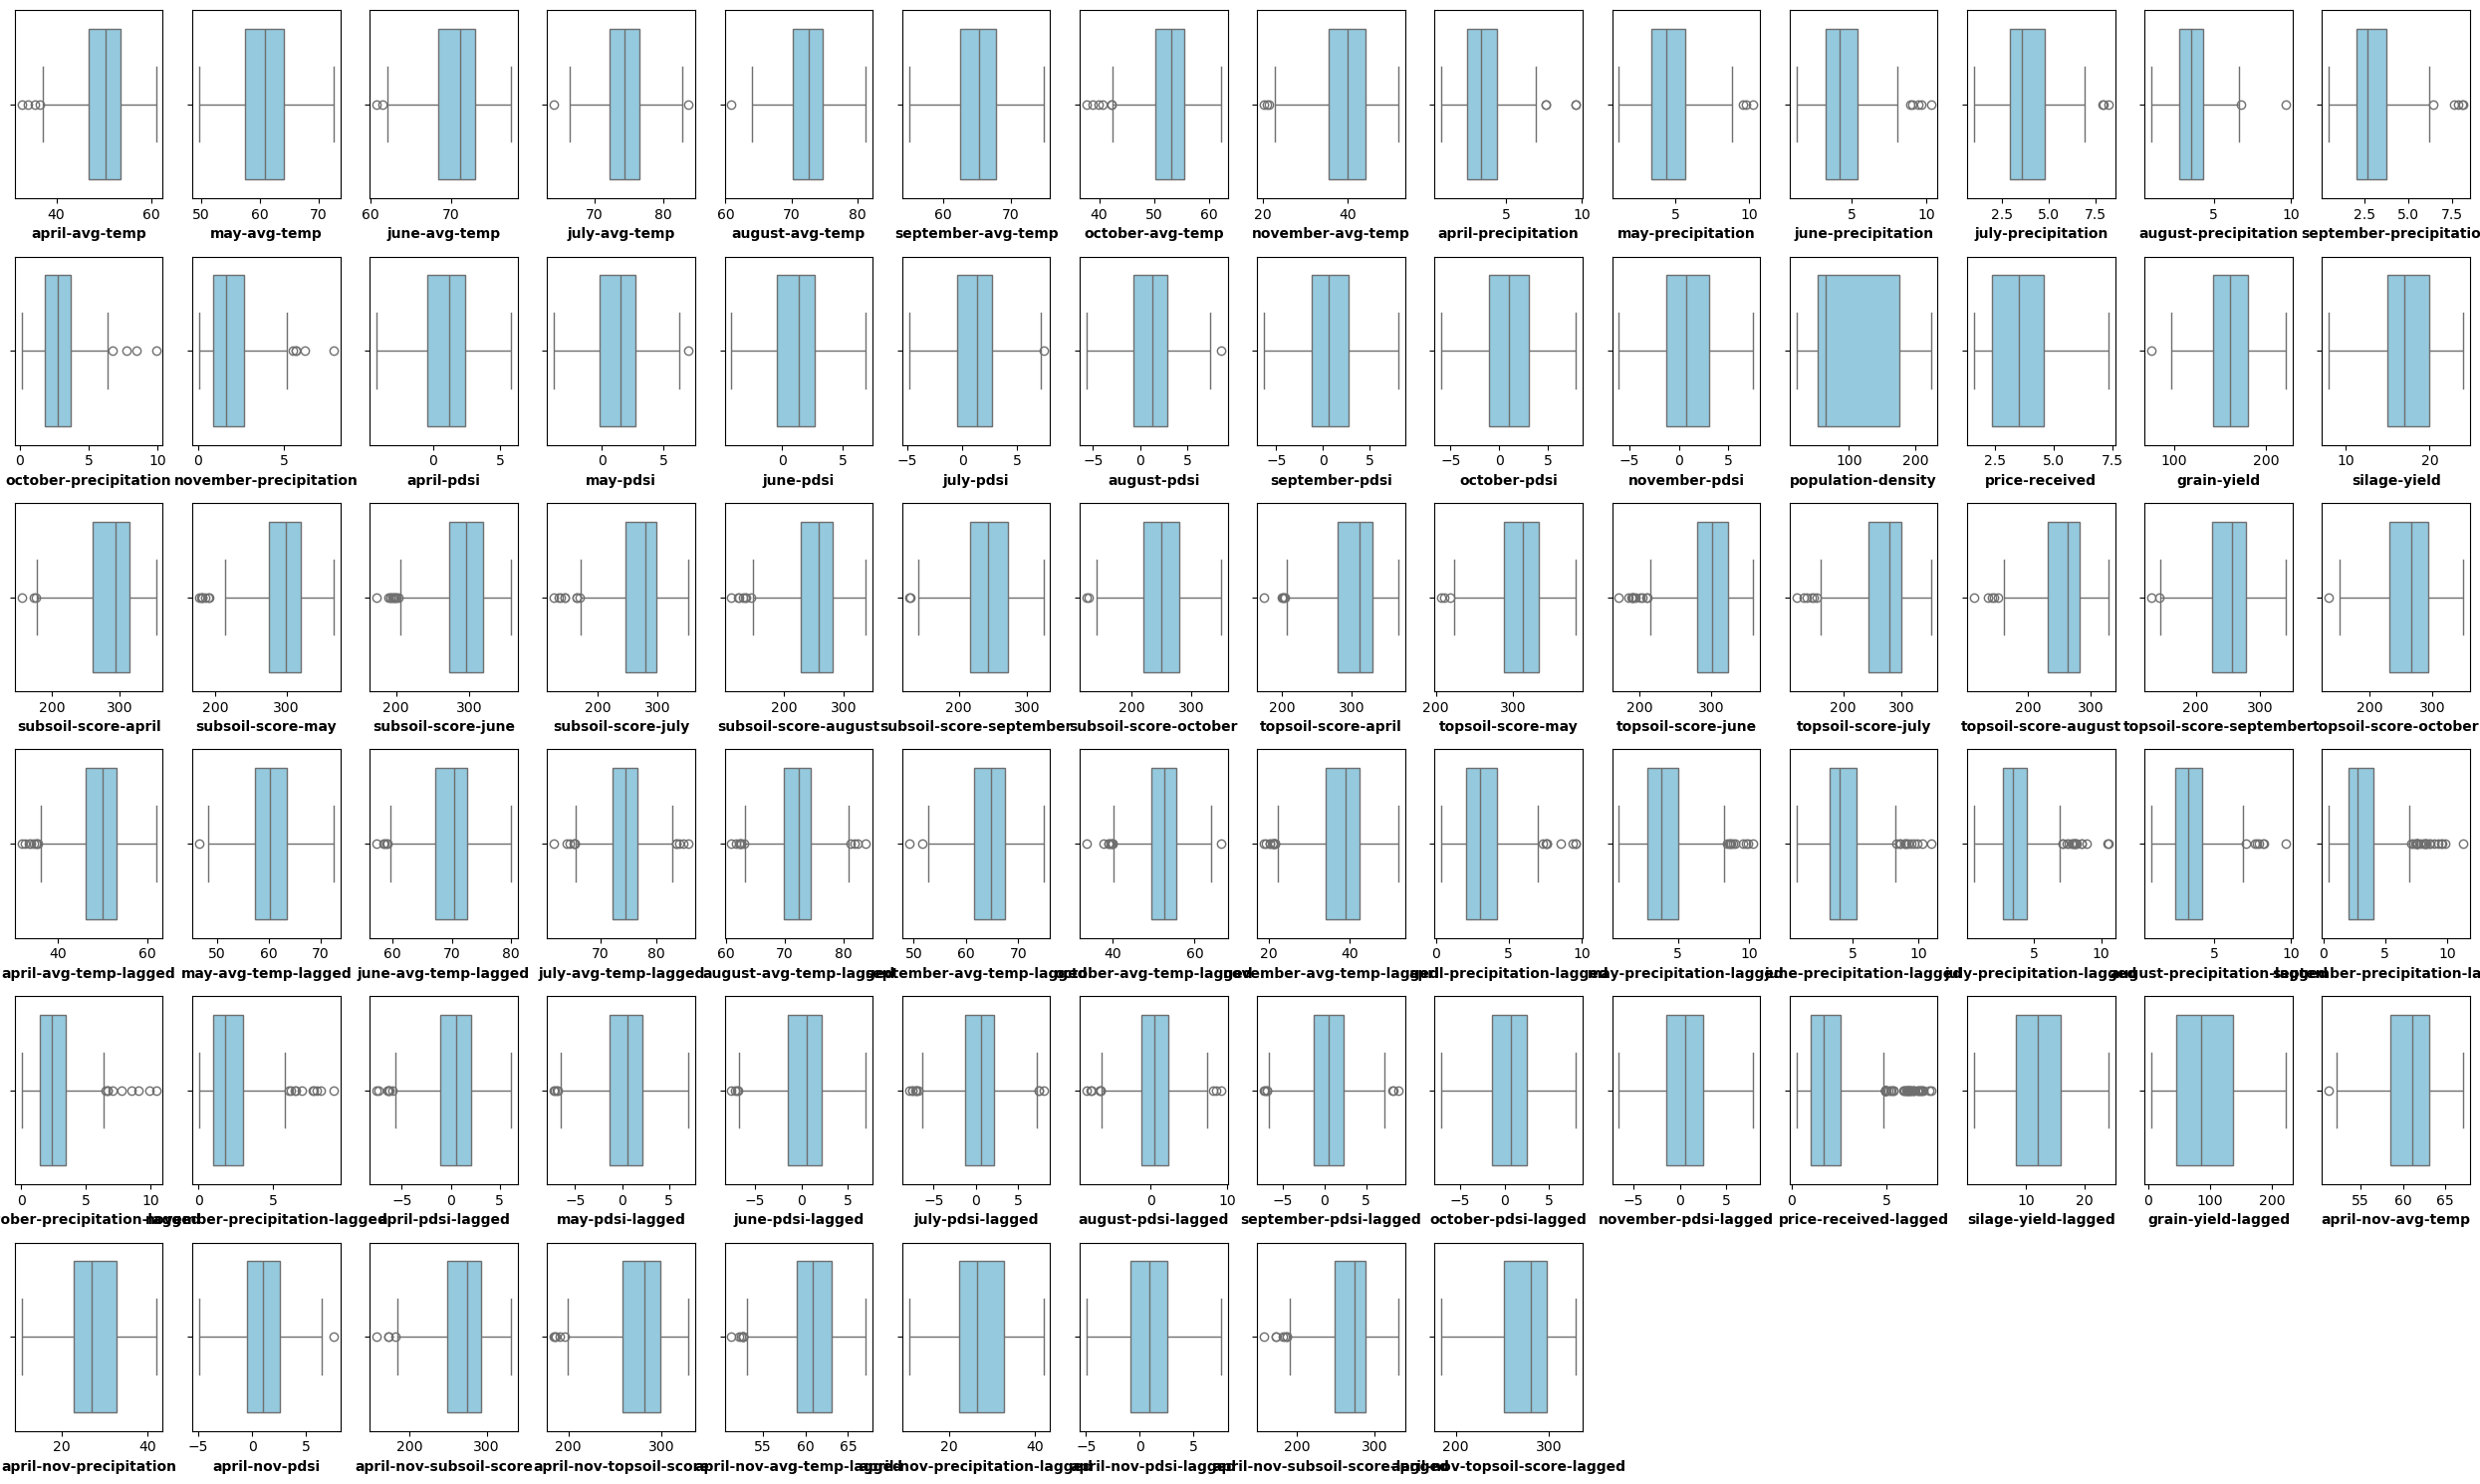

In [35]:
columns_19 = [col for col in df_19.columns if col not in '-lag'][2:]
columns_95 = [col for col in df_95.columns if col not in '-lag'][2:]
dfs_names = ['1919 to Present', '1995 to Present']

for i, df in enumerate([df_19, df_95]):

    if i == 0:
        columns = columns_19
        n_rows = 9
        n_cols = 7

    if i == 1:
        columns = columns_95
        n_rows = 6
        n_cols = 14

    fig = plt.figure()


    fig = plt.figure()

    for j, col in enumerate(columns):
        plt.subplot(n_rows, n_cols, j + 1)
        sns.boxplot(x=df[col], color='skyblue', orient='h')
        plt.xlabel(col, fontweight='bold')

    fig.set_figheight(15)
    fig.set_figwidth(25)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)

    fig.savefig(f'../results/{dfs_names[i].lower().replace(' ', '-')}-boxplots.png')

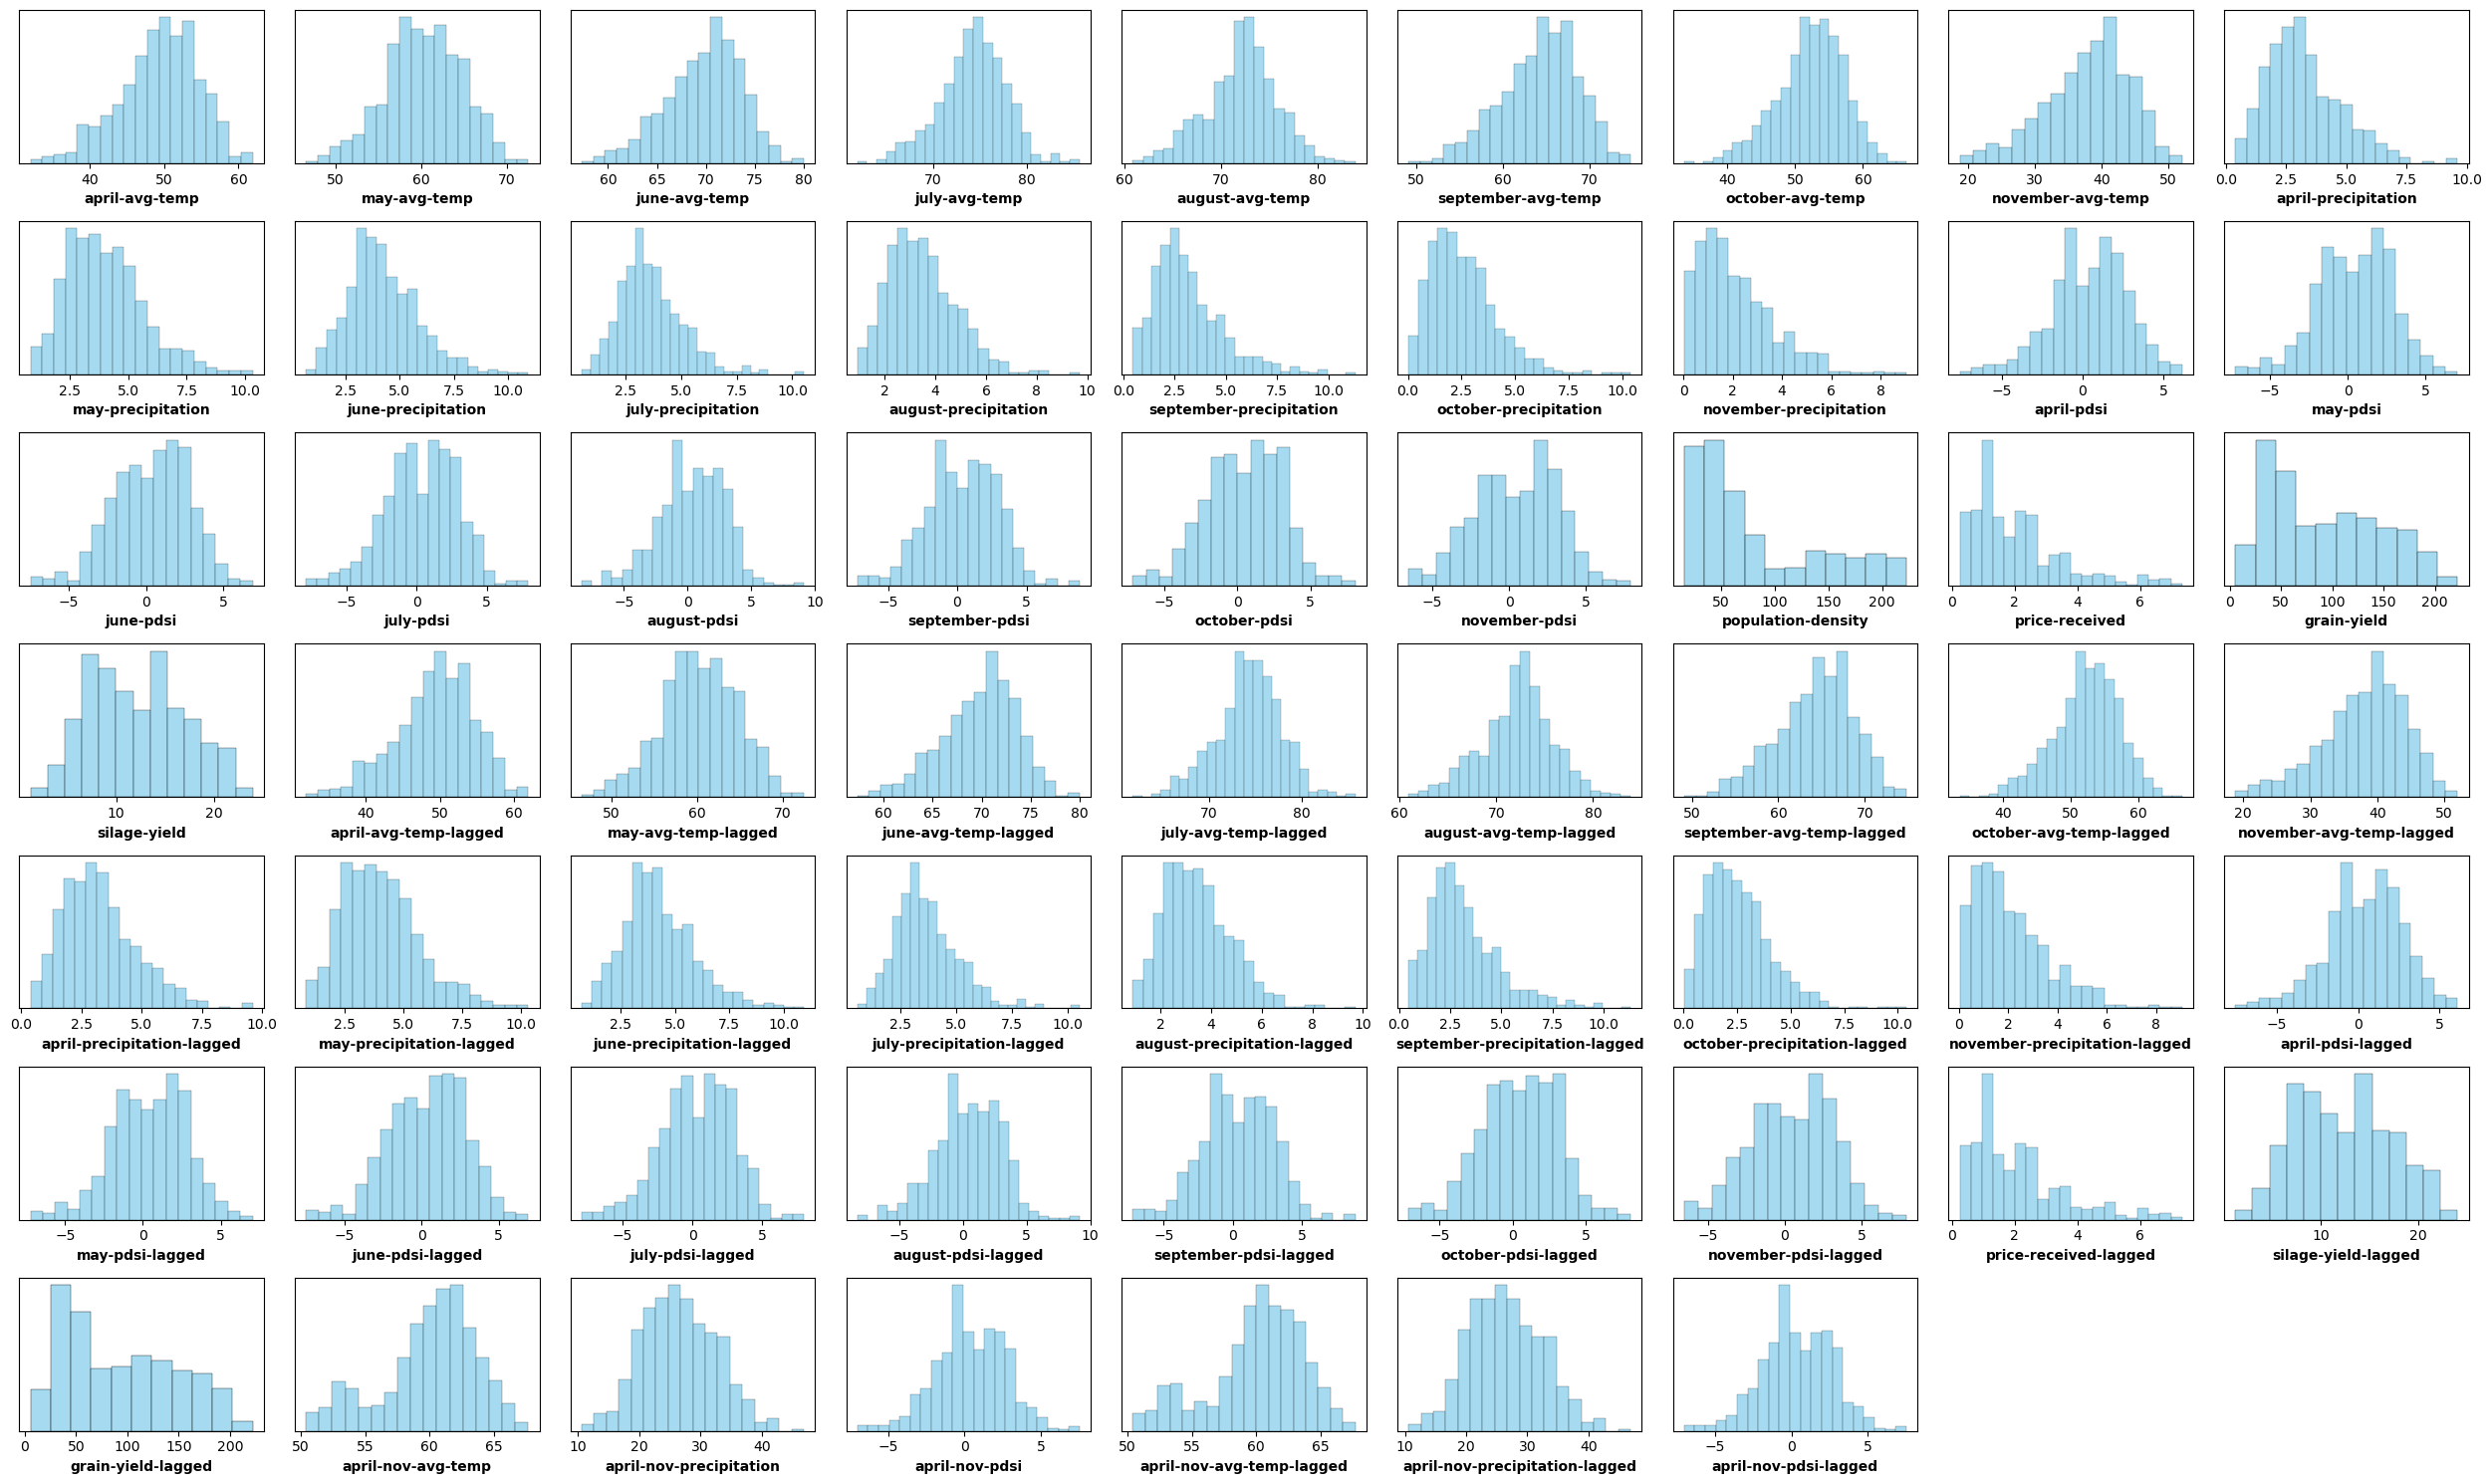

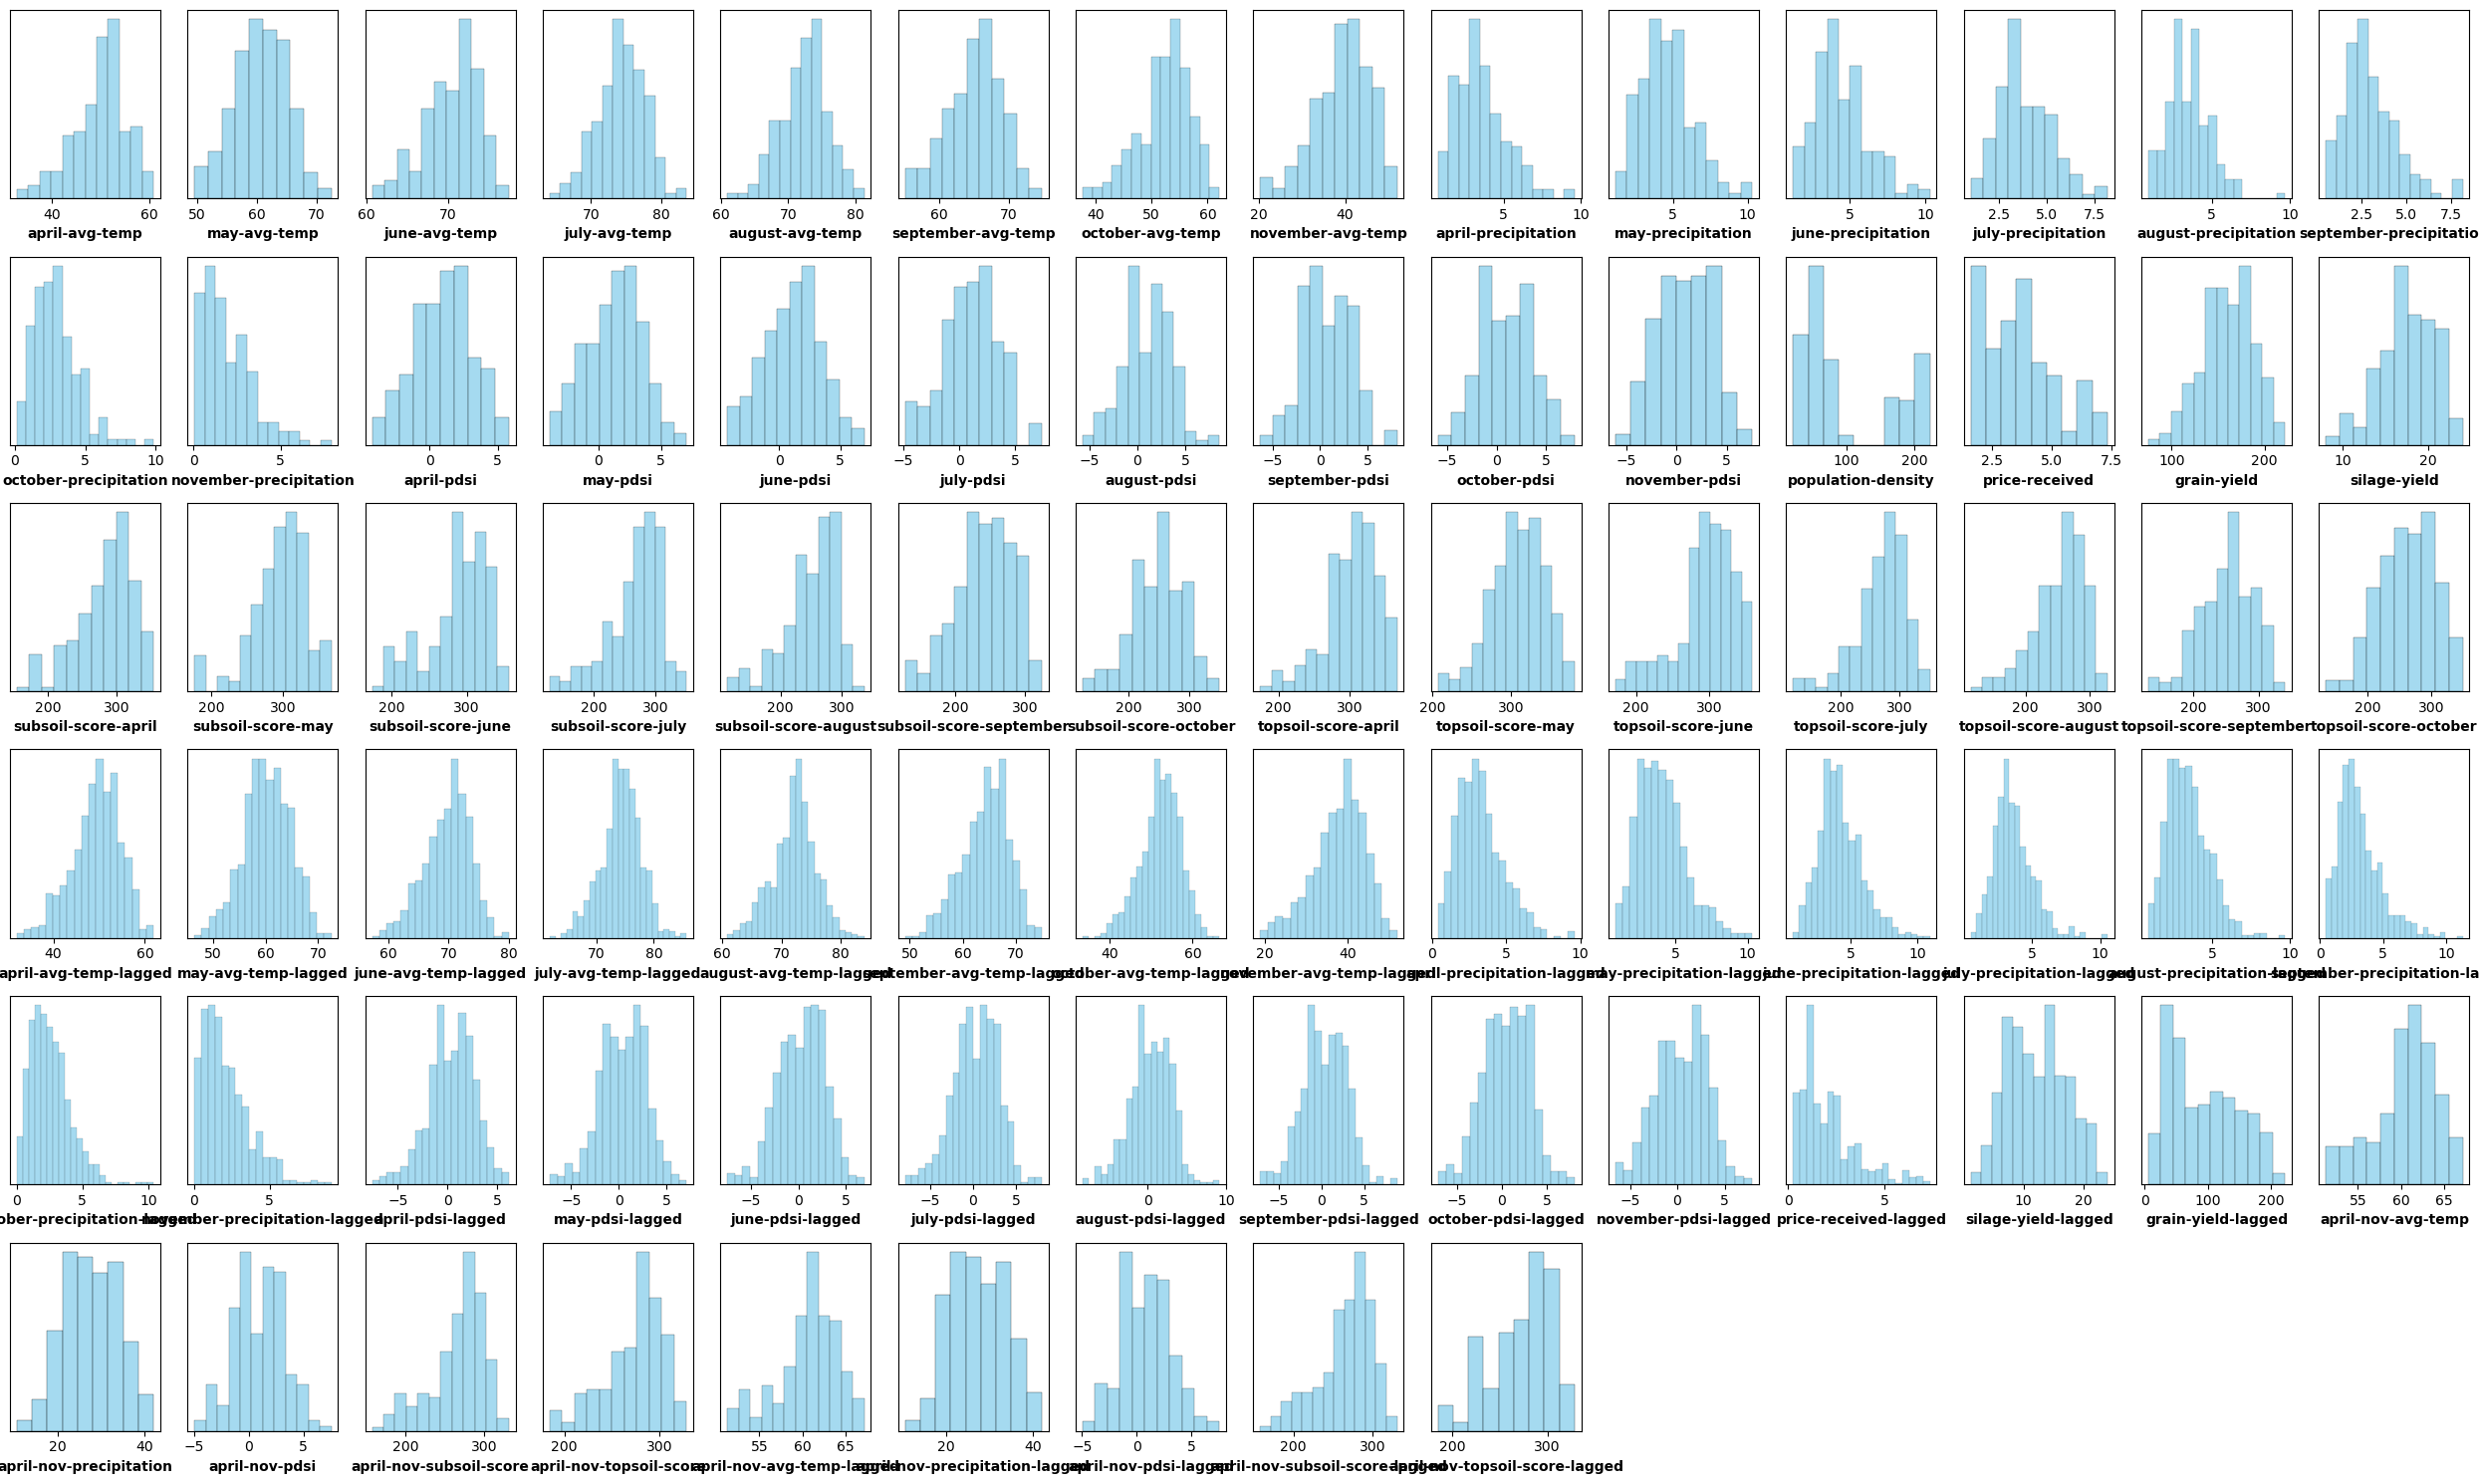

In [36]:
for i, df in enumerate([df_19, df_95]):

    if i == 0:
        columns = columns_19
        n_rows = 7
        n_cols = 9

    if i == 1:
        columns = columns_95
        n_rows = 6
        n_cols = 14

    fig = plt.figure()

    for j, col in enumerate(columns):

        ax1 = plt.subplot(n_rows, n_cols, j+1)
        sns.histplot(x=df[col], color='skyblue', ax=ax1)
        ax1.set_xlabel(col, fontweight='bold')
        ax1.set_ylabel('')
        ax1.set_yticks([])

    fig.set_figheight(15)
    fig.set_figwidth(25)
    fig.tight_layout()

    fig.savefig(f'../results/{dfs_names[i].replace(' ', '-')}-histograms.png')

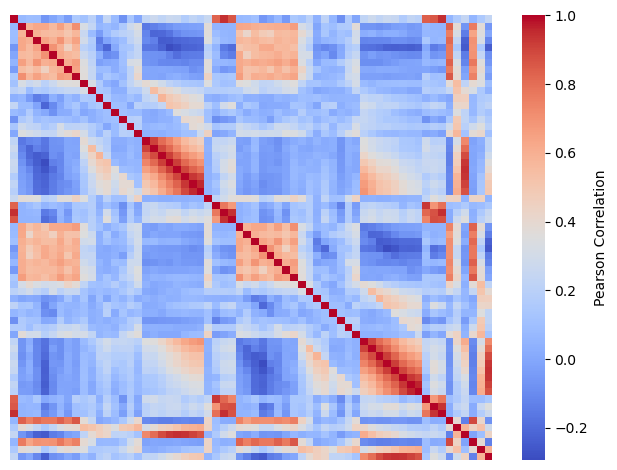

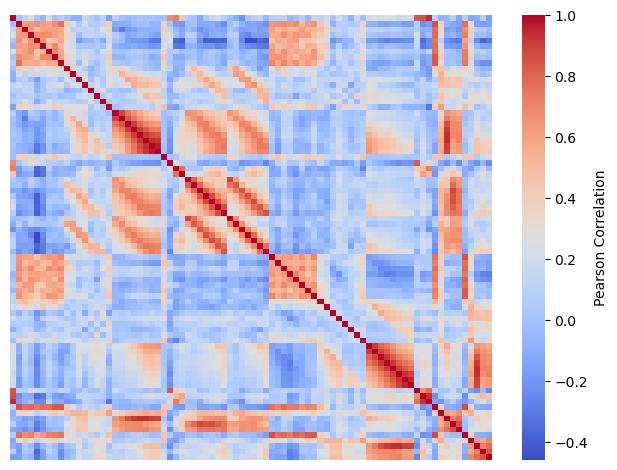

In [37]:
sns.heatmap(
    df_19.drop(columns='state').corr(),
    cmap='coolwarm',
    cbar_kws={'label': 'Pearson Correlation'}
)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig('../results/1919-heatmap.png')
plt.show()

sns.heatmap(
    df_95.drop(columns='state').corr(),
    cmap='coolwarm',
    cbar_kws={'label': 'Pearson Correlation'}
)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig('../results/1995-heatmap.png')
plt.show()

[Text(0, 0.0, ''),
 Text(0, 25.0, ''),
 Text(0, 50.0, ''),
 Text(0, 75.0, ''),
 Text(0, 100.0, ''),
 Text(0, 125.0, ''),
 Text(0, 150.0, ''),
 Text(0, 175.0, ''),
 Text(0, 200.0, '')]

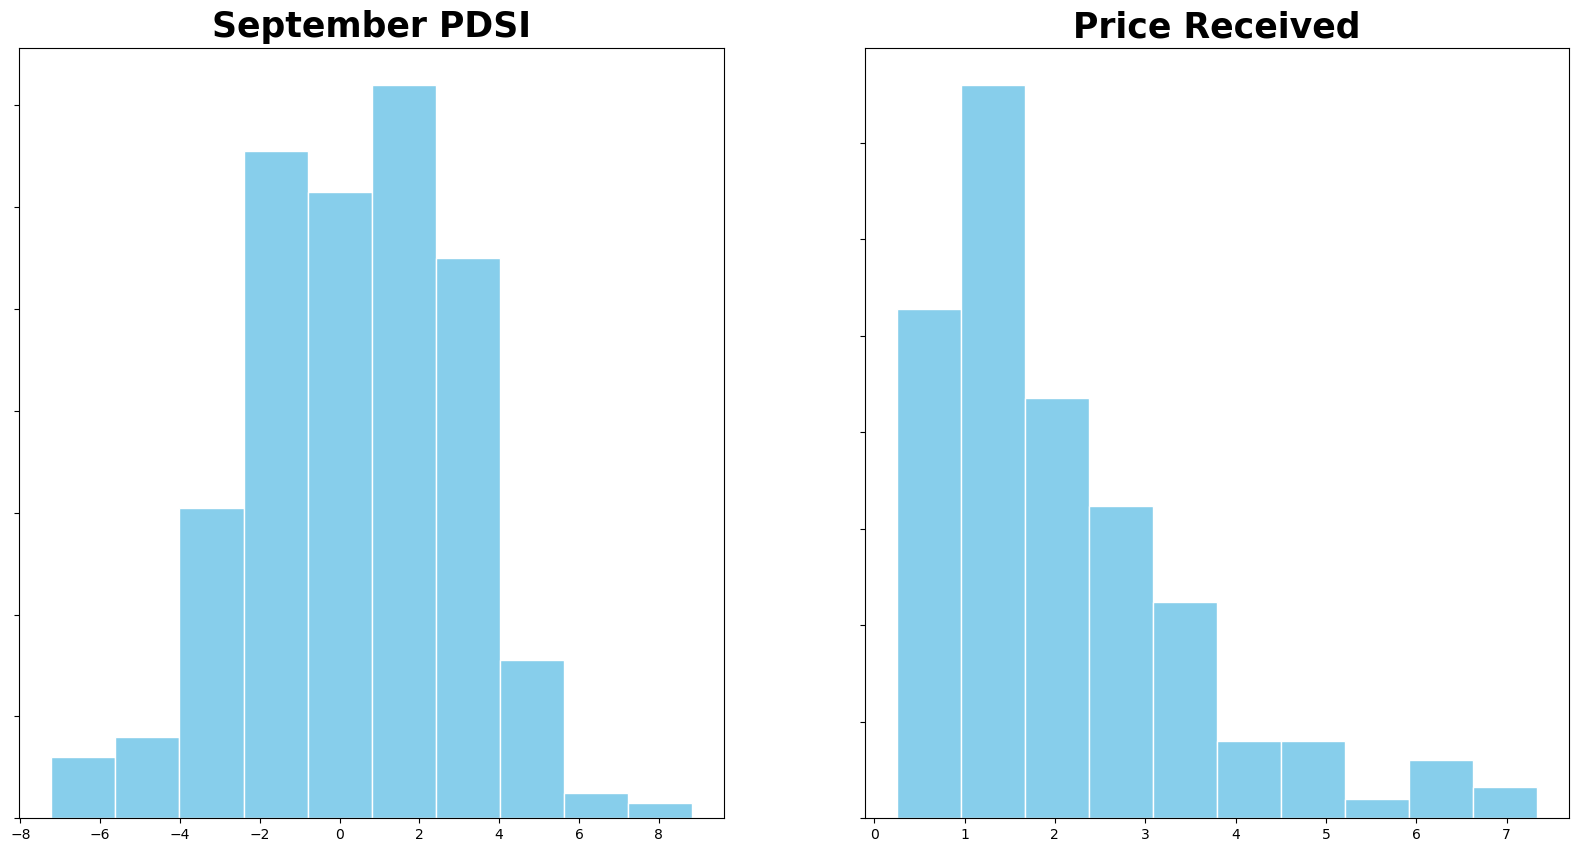

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].hist(
    df_19['september-pdsi'],
    color='skyblue',
    edgecolor='white'
)
axes[1].hist(
    df_19['price-received'],
    color='skyblue',
    edgecolor='white'
)

axes[0].set_xlabel('September PDSI', fontweight='bold', fontsize=25)
axes[1].set_xlabel('Price Received', fontweight='bold', fontsize=25)

axes[0].xaxis.set_label_coords(0.5, 1.05)
axes[1].xaxis.set_label_coords(0.5, 1.05)

axes[0].set_yticklabels('')
axes[1].set_yticklabels('')

Text(0.5, 0, 'Price Received')

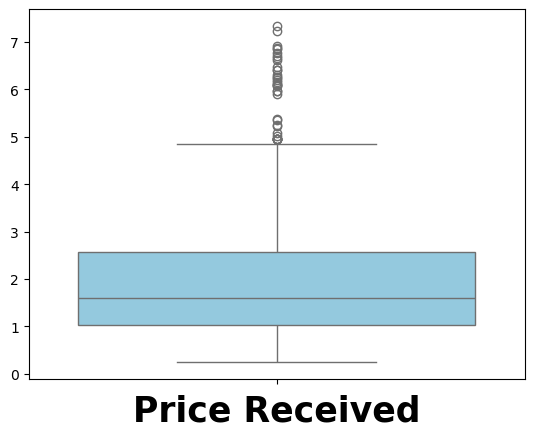

In [61]:
sns.boxplot(df_19['price-received'], color='skyblue')
plt.ylabel('')
plt.xlabel('Price Received', fontweight='bold', fontsize=25)